Modeling variance in a linear regression

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import daft
from causalgraphicalmodels import CausalGraphicalModel

sns.set_context("talk")

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

## Linear model with DAG

Now let's try to level up and do simulations based on a DAG.

Categorical variables (treatment or not, fungus or not)

h0 --> h1 <-- F <-- T

Let's imagine that final height is our variable of interest.

In [3]:
# number of samples
N = 100

# simulate heights
h = stats.norm.rvs(0, 1, size=N)

# simulate weights
bHW = 1.5
w = stats.norm.rvs(bHW * h, 1, size=N)

<IPython.core.display.Javascript object>

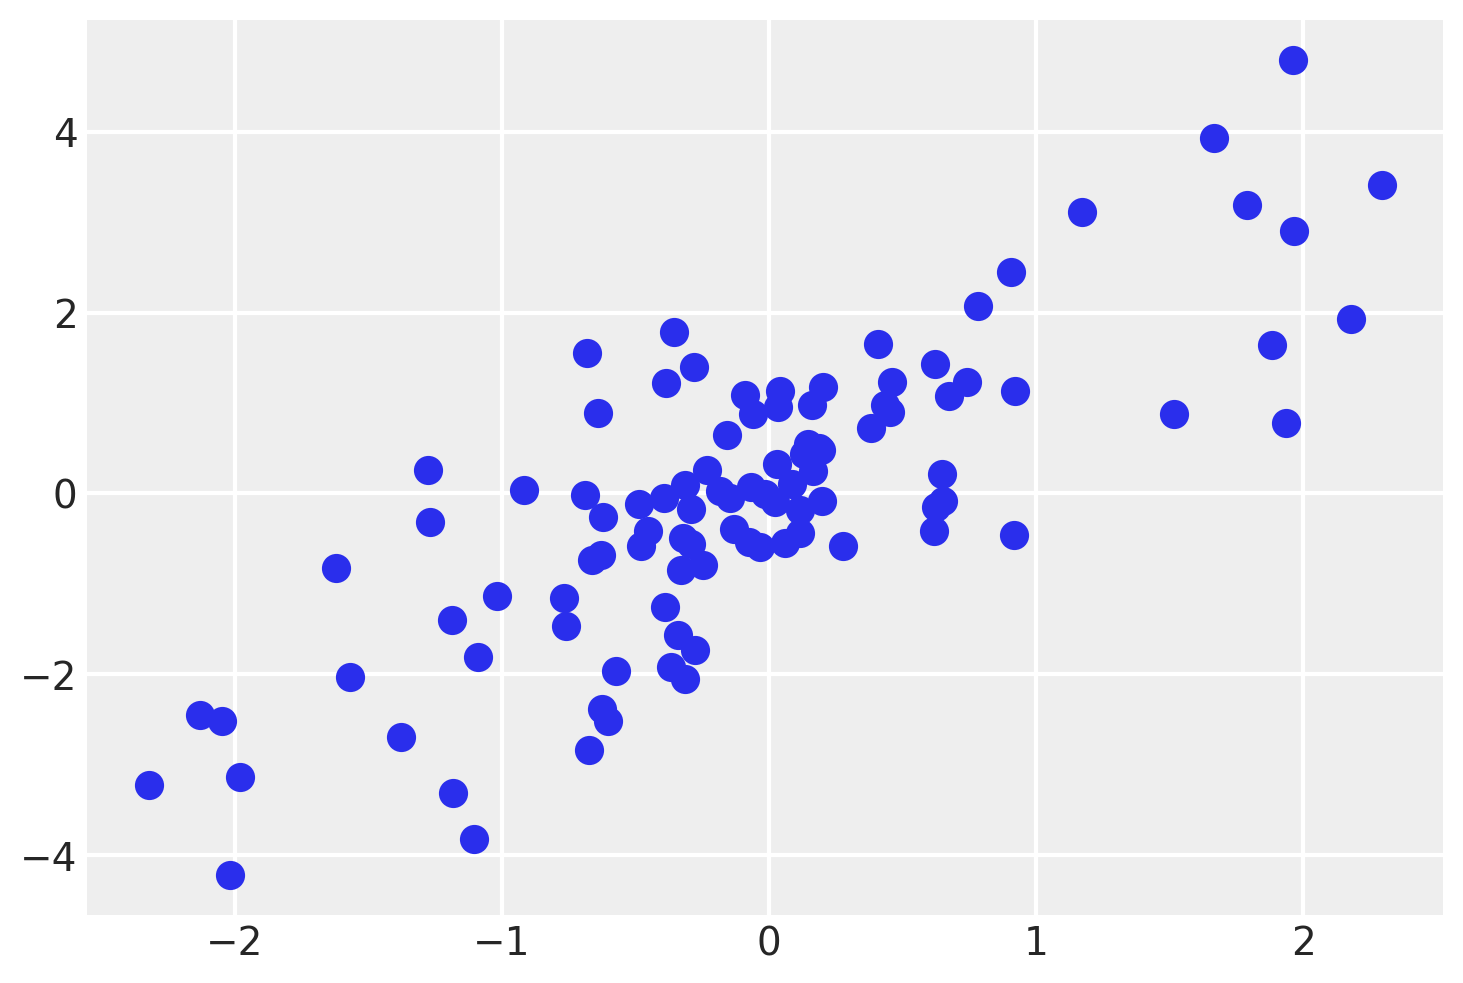

<IPython.core.display.Javascript object>

In [4]:
plt.scatter(h, w)

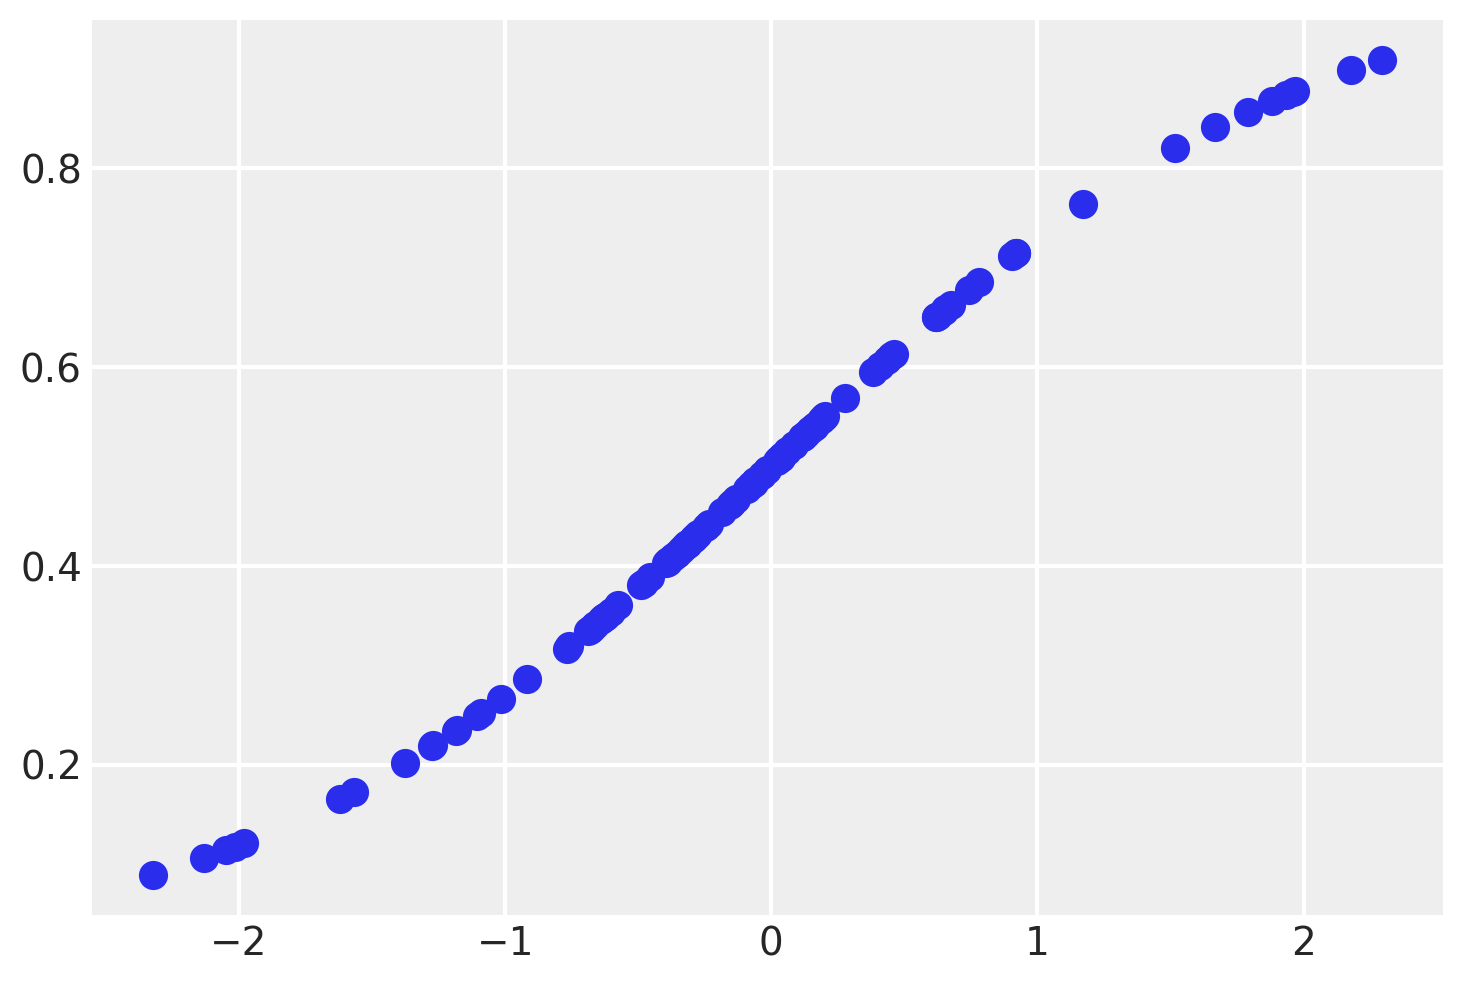

<IPython.core.display.Javascript object>

In [10]:
# model variance as a function of h

# simulate weights
bHW = 1.5

# model variance by constraining scale parameter with h
from scipy.special import expit

plt.scatter(h, expit(h))


In [13]:
w = stats.norm.rvs(bHW * h, expit(h), size=N)


<IPython.core.display.Javascript object>

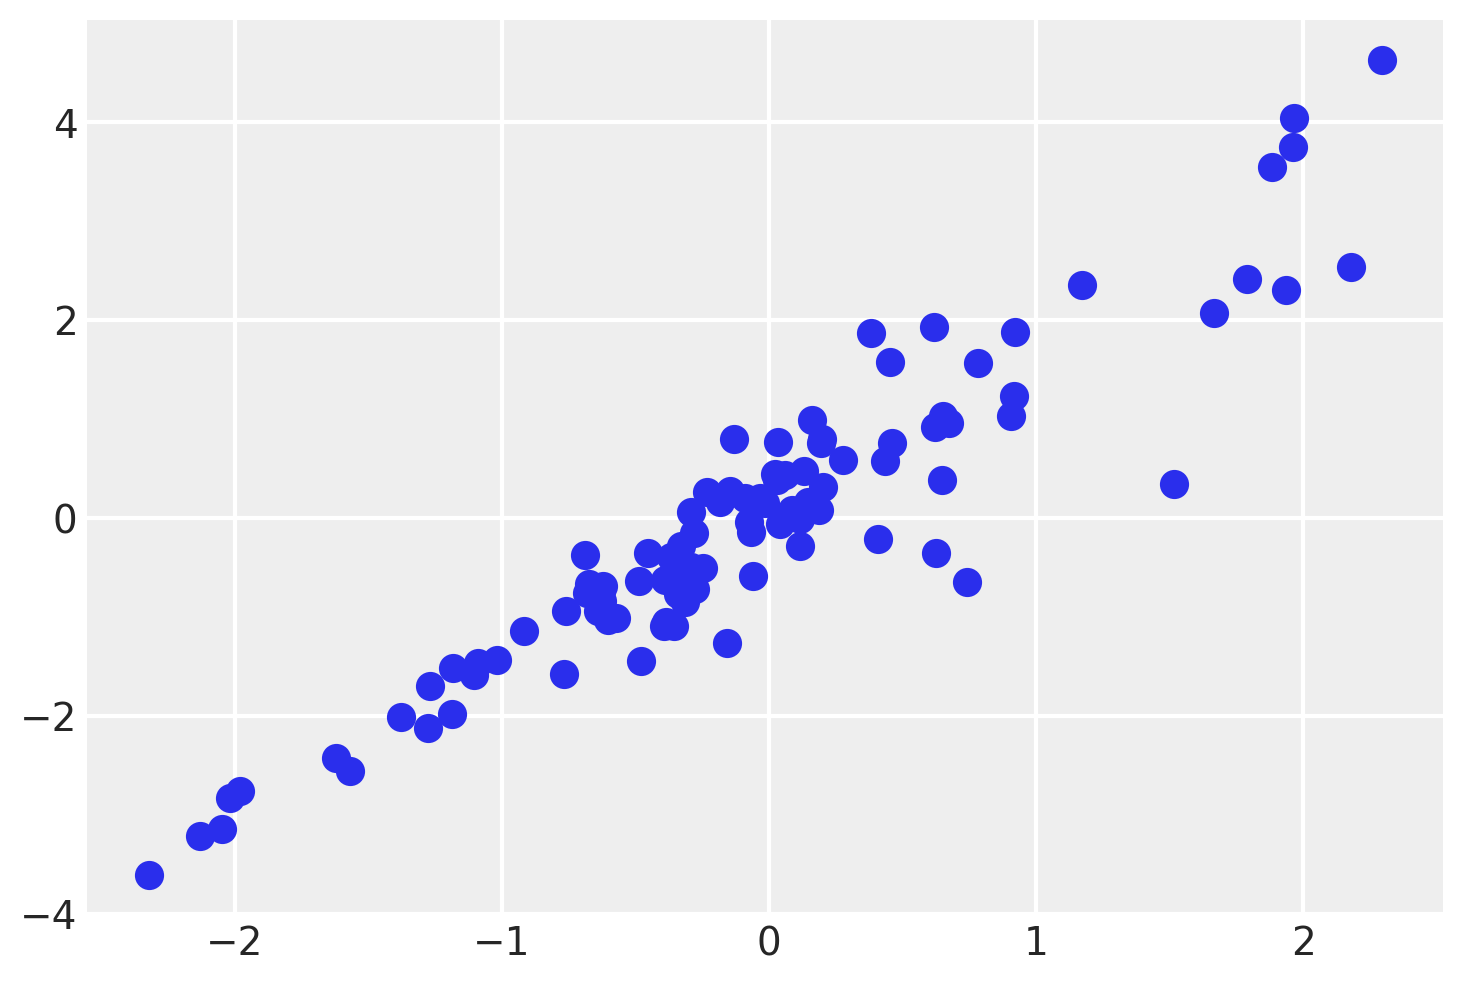

<IPython.core.display.Javascript object>

In [14]:
plt.scatter(h, w)

# Make data increase confidence of model in a certain part of the x-axis.



```
mu = a + bx
s = g*x
````

In [22]:
# 100 numbers between 10 and 100

n = 100
h = np.linspace(10, 100, n)
h

array([ 10.        ,  10.90909091,  11.81818182,  12.72727273,
        13.63636364,  14.54545455,  15.45454545,  16.36363636,
        17.27272727,  18.18181818,  19.09090909,  20.        ,
        20.90909091,  21.81818182,  22.72727273,  23.63636364,
        24.54545455,  25.45454545,  26.36363636,  27.27272727,
        28.18181818,  29.09090909,  30.        ,  30.90909091,
        31.81818182,  32.72727273,  33.63636364,  34.54545455,
        35.45454545,  36.36363636,  37.27272727,  38.18181818,
        39.09090909,  40.        ,  40.90909091,  41.81818182,
        42.72727273,  43.63636364,  44.54545455,  45.45454545,
        46.36363636,  47.27272727,  48.18181818,  49.09090909,
        50.        ,  50.90909091,  51.81818182,  52.72727273,
        53.63636364,  54.54545455,  55.45454545,  56.36363636,
        57.27272727,  58.18181818,  59.09090909,  60.        ,
        60.90909091,  61.81818182,  62.72727273,  63.63636364,
        64.54545455,  65.45454545,  66.36363636,  67.27

<IPython.core.display.Javascript object>

In [36]:
w = stats.norm.rvs(bHW * h, h/4, size=N)

<IPython.core.display.Javascript object>

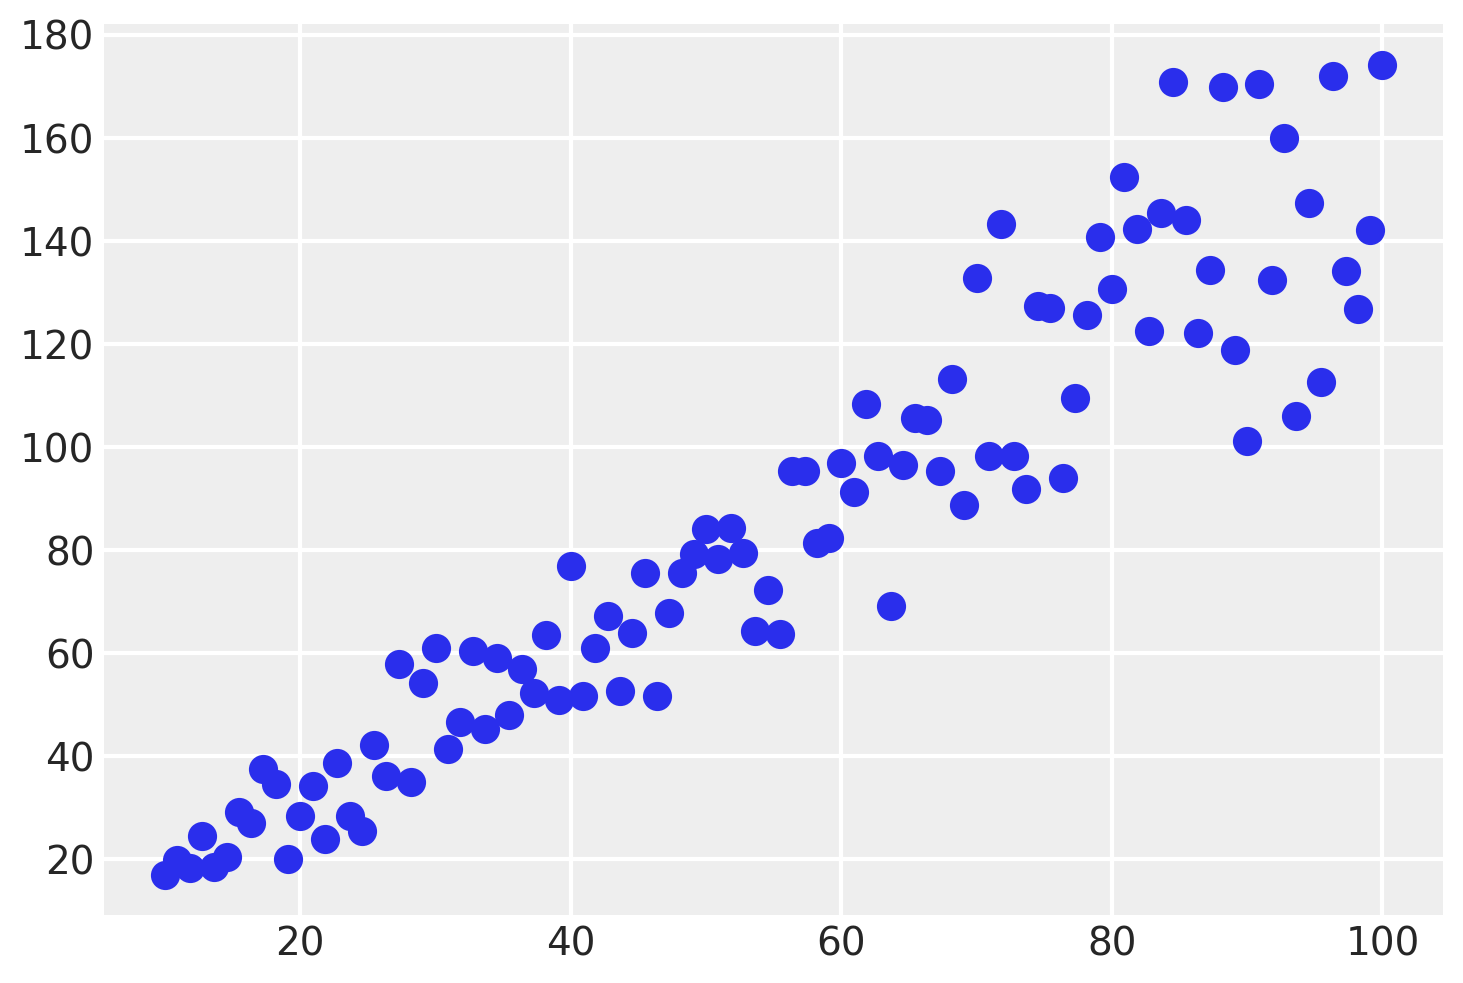

<IPython.core.display.Javascript object>

In [37]:
plt.scatter(h, w)

In [97]:
h = np.linspace(10, 100, n)
w1 = stats.norm.rvs(bHW * h[0:50], 10, size=50) #.shape(N/2, 1)
w2 = stats.norm.rvs(bHW * h[50::], 5, size=50) #.shape=(N/2, 1)
w = np.concatenate([w1, w2])



<IPython.core.display.Javascript object>

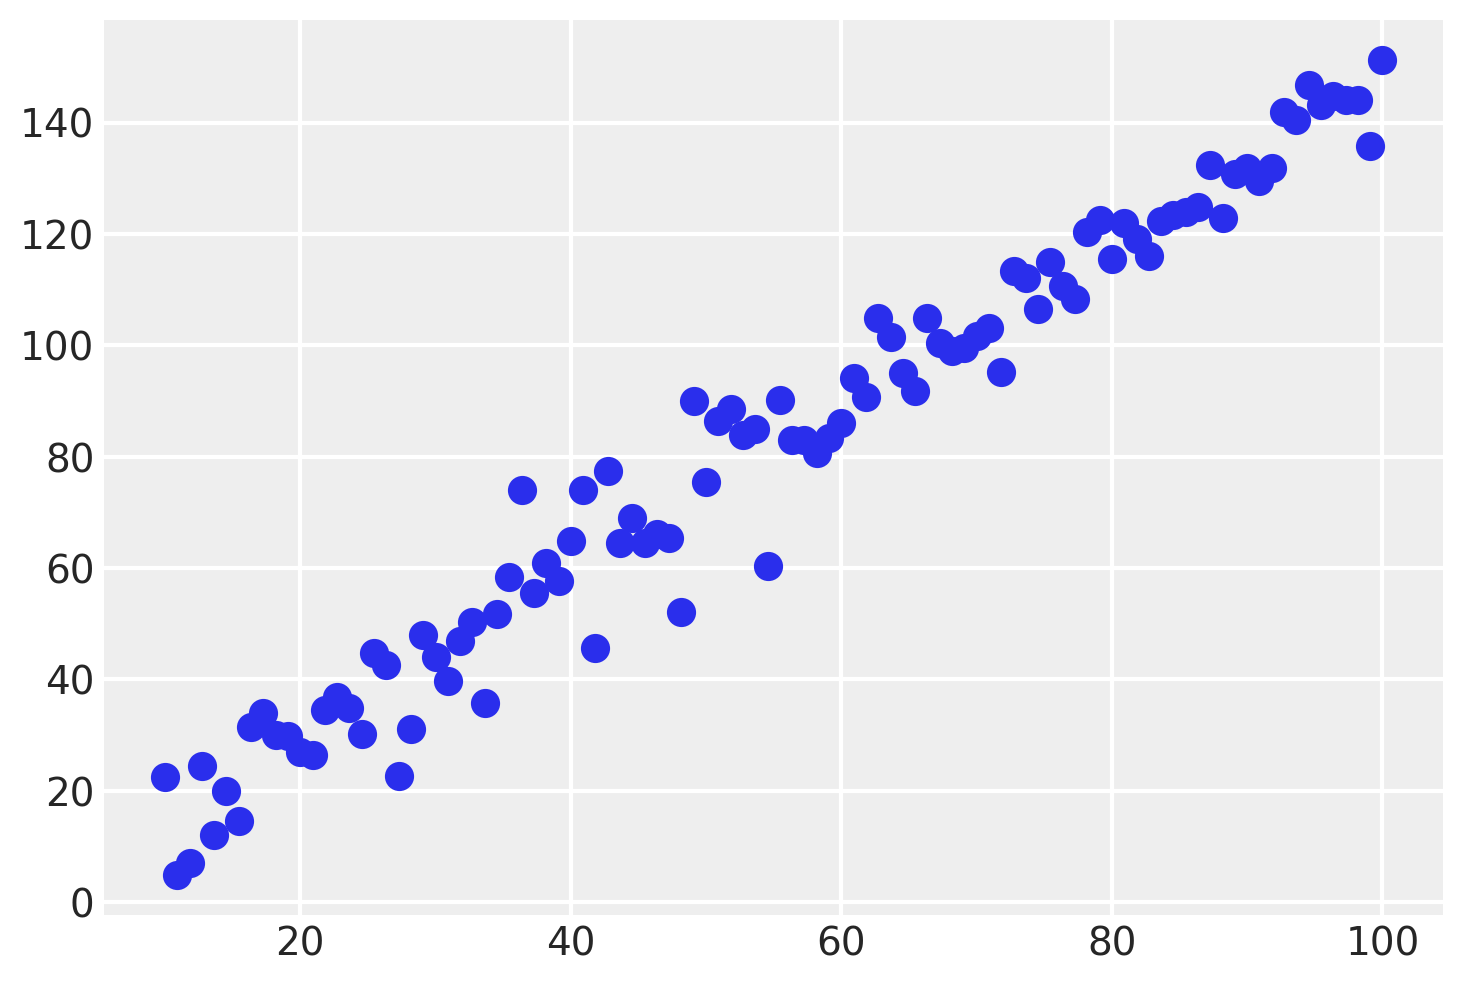

<IPython.core.display.Javascript object>

In [98]:
plt.scatter(h, w)

Categorical model?

In [42]:
with pm.Model() as m1:
    # Priors
    a = pm.Normal("a", mu=0, sd=1)
    b = pm.Normal("b", mu=0, sd=1)
    g = pm.Lognormal("g", 1)

    # Linear models
    mu = a + b * h
    s = g * h

    # Observation
    y = pm.Normal("y", mu=mu, sd=s, observed=w)

    # Inference
    idata = pm.sample(1000, chains=4, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [43]:
az.summary(idata)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.598,0.820,-0.710,1.859,0.016,0.011,2615.0,2615.0,2615.0,2903.0,1.0
b,1.525,0.034,1.475,1.583,0.001,0.000,2445.0,2441.0,2451.0,2869.0,1.0
g,0.260,0.019,0.229,0.289,0.000,0.000,3218.0,3202.0,3221.0,2547.0,1.0


<IPython.core.display.Javascript object>

In [44]:
with m1:
    post_pc = pm.sample_posterior_predictive(idata, samples=100)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<IPython.core.display.Javascript object>

In [45]:
post_pc

{'y': array([[ 16.3972936 ,  15.45194579,  16.07830102, ..., 173.76961389,
         134.66425035, 186.85412152],
        [ 14.51763846,  17.64345809,  20.52775396, ..., 173.26665289,
         159.9371358 , 159.00489025],
        [ 11.40942507,  15.90283495,  18.96083868, ..., 102.64049541,
         186.00961279, 157.39224466],
        ...,
        [ 13.04921236,  13.47847348,  16.00191808, ..., 109.06865501,
         127.44633965, 215.30511484],
        [ 18.7465349 ,  23.06778775,  18.35856078, ..., 132.3789747 ,
         106.57882862, 137.82225194],
        [ 15.72318175,  22.25515554,  22.4562759 , ...,  91.06864172,
         121.9314157 , 136.16095611]])}

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


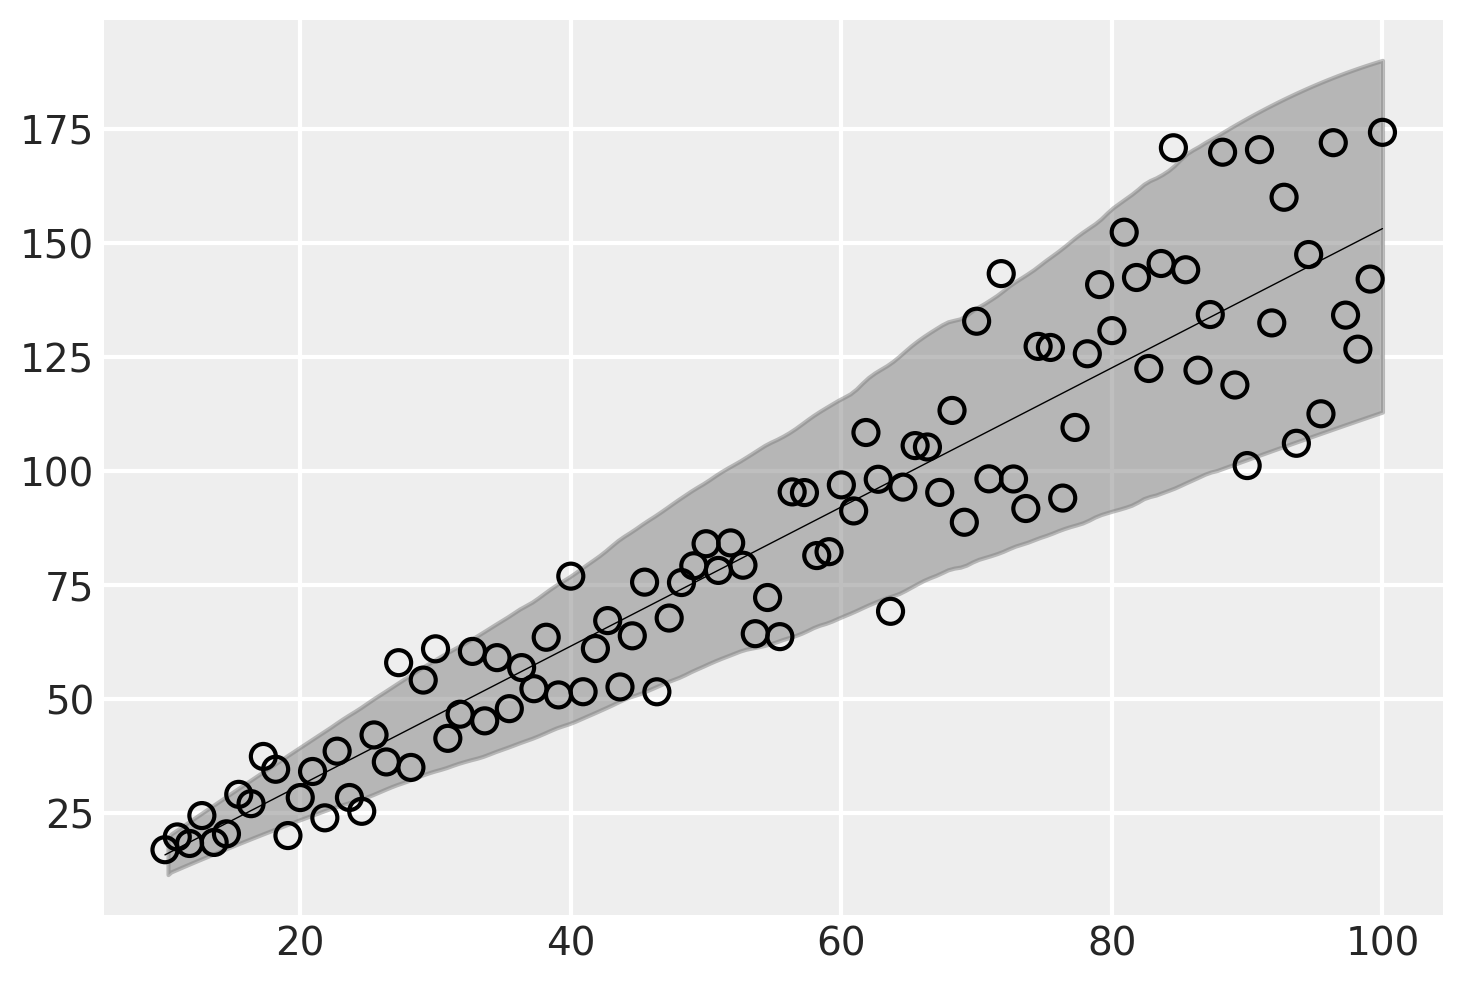

<IPython.core.display.Javascript object>

In [53]:
iqdata_df = idata.to_dataframe()

f, ax1 = plt.subplots()

# Plotting the overall mean line
ax1.plot(
    h,
    iqdata_df[('posterior', 'a')].mean() + iqdata_df[('posterior', 'b')].mean() * h,
    label="posterior mean line",
    linewidth=0.5,
    color="black",
)

# Uncertainty around all predictions
az.plot_hdi(h, post_pc["y"], color='gray', ax=ax1)

# All raw data
ax1.scatter(h, w, facecolors='none', edgecolors='k')

# Have variance adjust with amount of data

In [57]:
h = stats.norm.rvs(60, 20, size=N)
h.min(), h.max()

(15.016783525695423, 106.15412339024518)

<IPython.core.display.Javascript object>

In [69]:
w = stats.norm.rvs(1 * h, h/5, size=N)

<IPython.core.display.Javascript object>

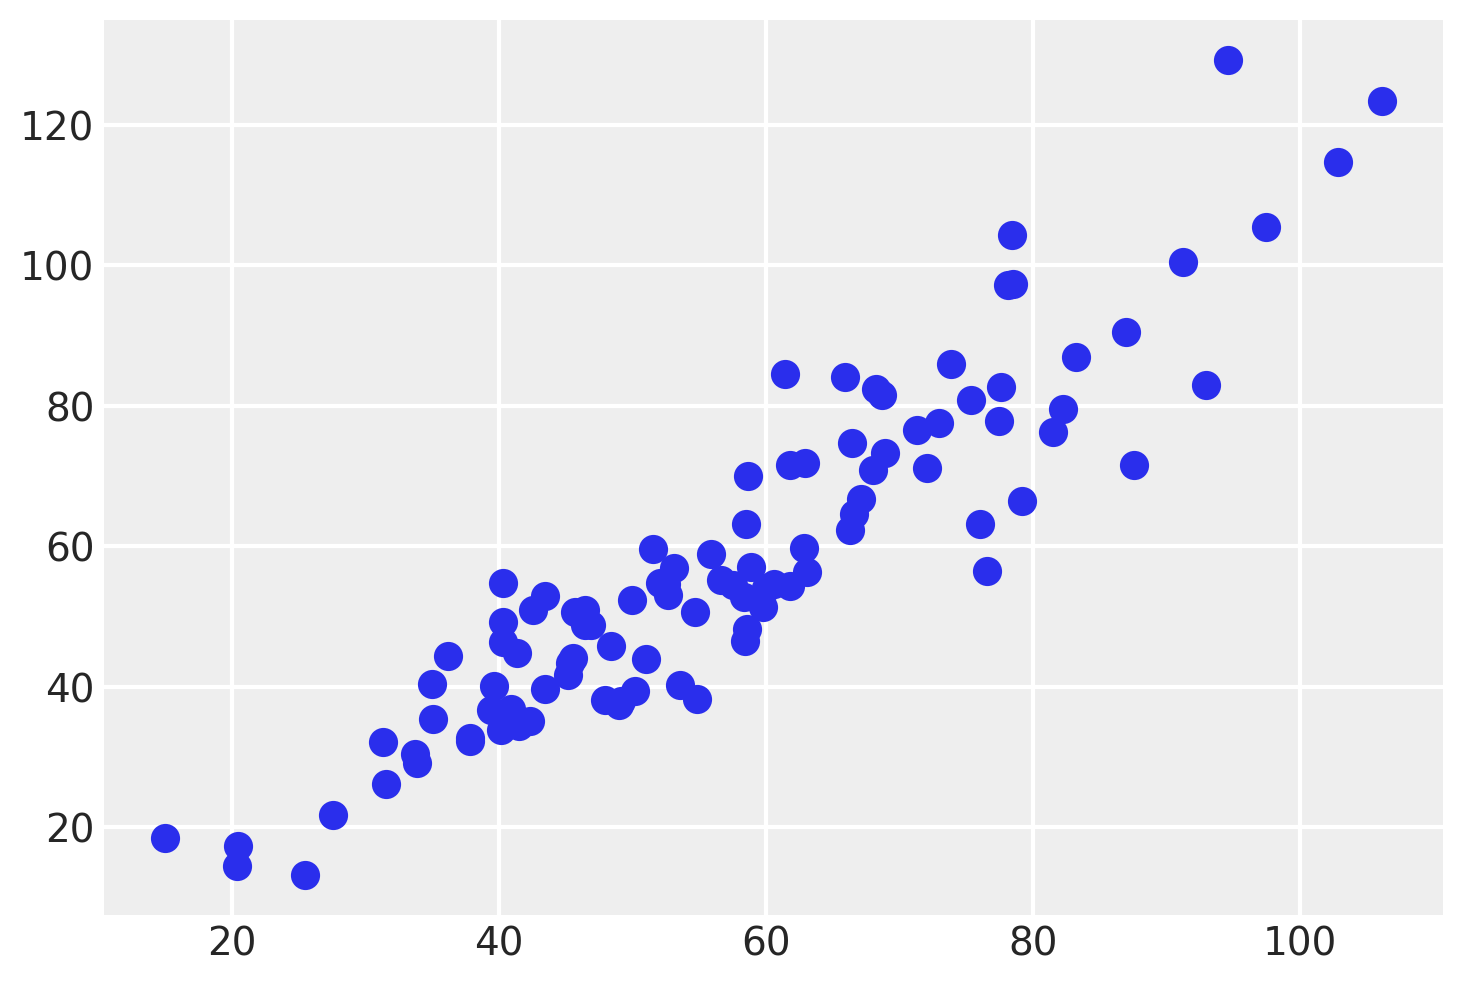

<IPython.core.display.Javascript object>

In [70]:
plt.scatter(h, w)

In [25]:
# OTHER

<IPython.core.display.Javascript object>

In [4]:
df_sim_plants = pd.DataFrame(
        {"h0":h0,
        "h1":h1,
        "T":treatment,
        "F":fungus}
    )

df_sim_plants.head()

,h0,h1,T,F
0,9.417136,13.263214,0,1
1,7.459338,9.471512,0,1
2,11.839598,17.719684,0,0
3,14.588947,19.582066,0,0
4,9.322042,13.225175,0,0


<IPython.core.display.Javascript object>

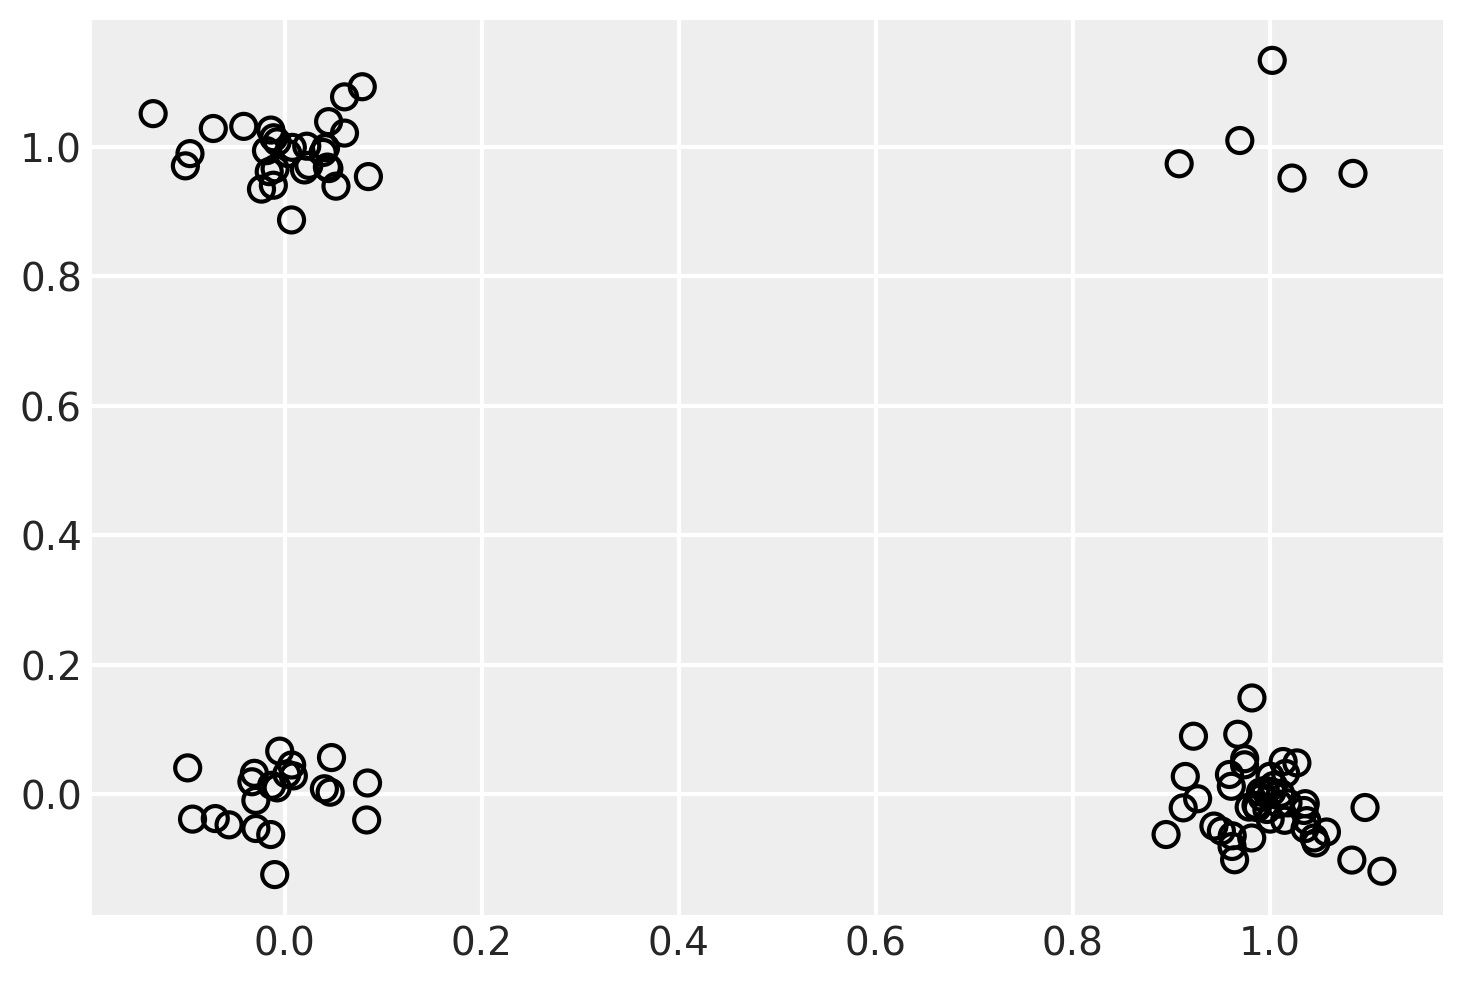

<IPython.core.display.Javascript object>

In [15]:
x_jitter = np.random.normal(0, 0.05, size=len(df_sim_plants))
y_jitter = np.random.normal(0, 0.05, size=len(df_sim_plants))
f, ax1 = plt.subplots()
ax1.scatter(
    df_sim_plants['T'] + x_jitter,
    df_sim_plants['F'] + y_jitter,
    facecolors='none',
    edgecolors='k'
)

In [5]:
az.summary(df_sim_plants.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,9.82,1.89,5.35,11.84
h1,13.81,2.24,9.47,16.63
T,0.50,0.50,0.00,1.00
F,0.34,0.48,0.00,1.00


<IPython.core.display.Javascript object>

Feed data back into a model. First, use proportions because we don't know absolute height.

Will reference variables by dataframe since that's how we'd get our data.

In [6]:
with pm.Model() as m3:
    
    # priors
    p = pm.Lognormal("p", 0, 0.25) 
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = p*df_sim_plants['h0']

    # likelihood
    h1 = pm.Normal("h1", mu, sigma, observed=df_sim_plants['h1'])

    # prior predictive checks
    prior_checks_m3 = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m3 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


<IPython.core.display.Javascript object>

We can look at the prior predictive simulation to determine the range of how we expect height to change.

In [7]:
az.summary(prior_checks_m3['p'])

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,1.033,0.264,0.625,1.425,0.001,0.001,97869.0,97869.0,97828.0,99658.0,NaN


<IPython.core.display.Javascript object>

We can look at the highest probability density interval and say that the height of the plant may shrink to ~60% of its original height or grow to just over 40% of its original height. Remember that this is just based off the priors.

Now let's actually take a look at how the data changes our predictions.

In [256]:
az.summary(trace_m3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,1.421,0.018,1.394,1.449,0.000,0.000,3886.0,3886.0,3895.0,2896.0,1.0
sigma,1.764,0.126,1.570,1.969,0.002,0.001,3712.0,3650.0,3780.0,2534.0,1.0


<IPython.core.display.Javascript object>

Here, we're more confident that the range is around 40% growth. Now let's actually take into account information from the DAG.

In [ ]:
with pm.Model() as m4:
    
    # priors
    p = pm.Lognormal("p", 0, 0.25) 
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = p*df_sim_plants['h0']

    # likelihood
    h1 = pm.Normal("h1", mu, sigma, observed=df_sim_plants['h1'])

    # prior predictive checks
    prior_checks_m4 = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m4 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

In [58]:
prior_checks_m4

NameError: name 'prior_checks_m4' is not defined

<IPython.core.display.Javascript object>

# 15M4

Simulate the following DAG: X -> Y -> Z. 

Now build a model predicting Y using both X and Z. What is the confound that arises?

$$ Y = \beta_1X + \beta_2Z $$

In [10]:
# start with x coming from random draws of a normal distribution around 0
X = stats.norm.rvs(0, 1, size=100)
bX_sim = 0.7

# make y come from random draws of a normal distribution around x
# use a known coefficient
Y = bX_sim * stats.norm.rvs(X, 1, size=100)
bY_sim = 0.3

# make z come from random draws of a normal distribution around x
Z = np.random.normal(Y, 1, size=100)
# Z = np.random.normal(0, 1, size=100)*Y +

df_sim = pd.DataFrame({"X": X, "Y": Y, "Z": Z})

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


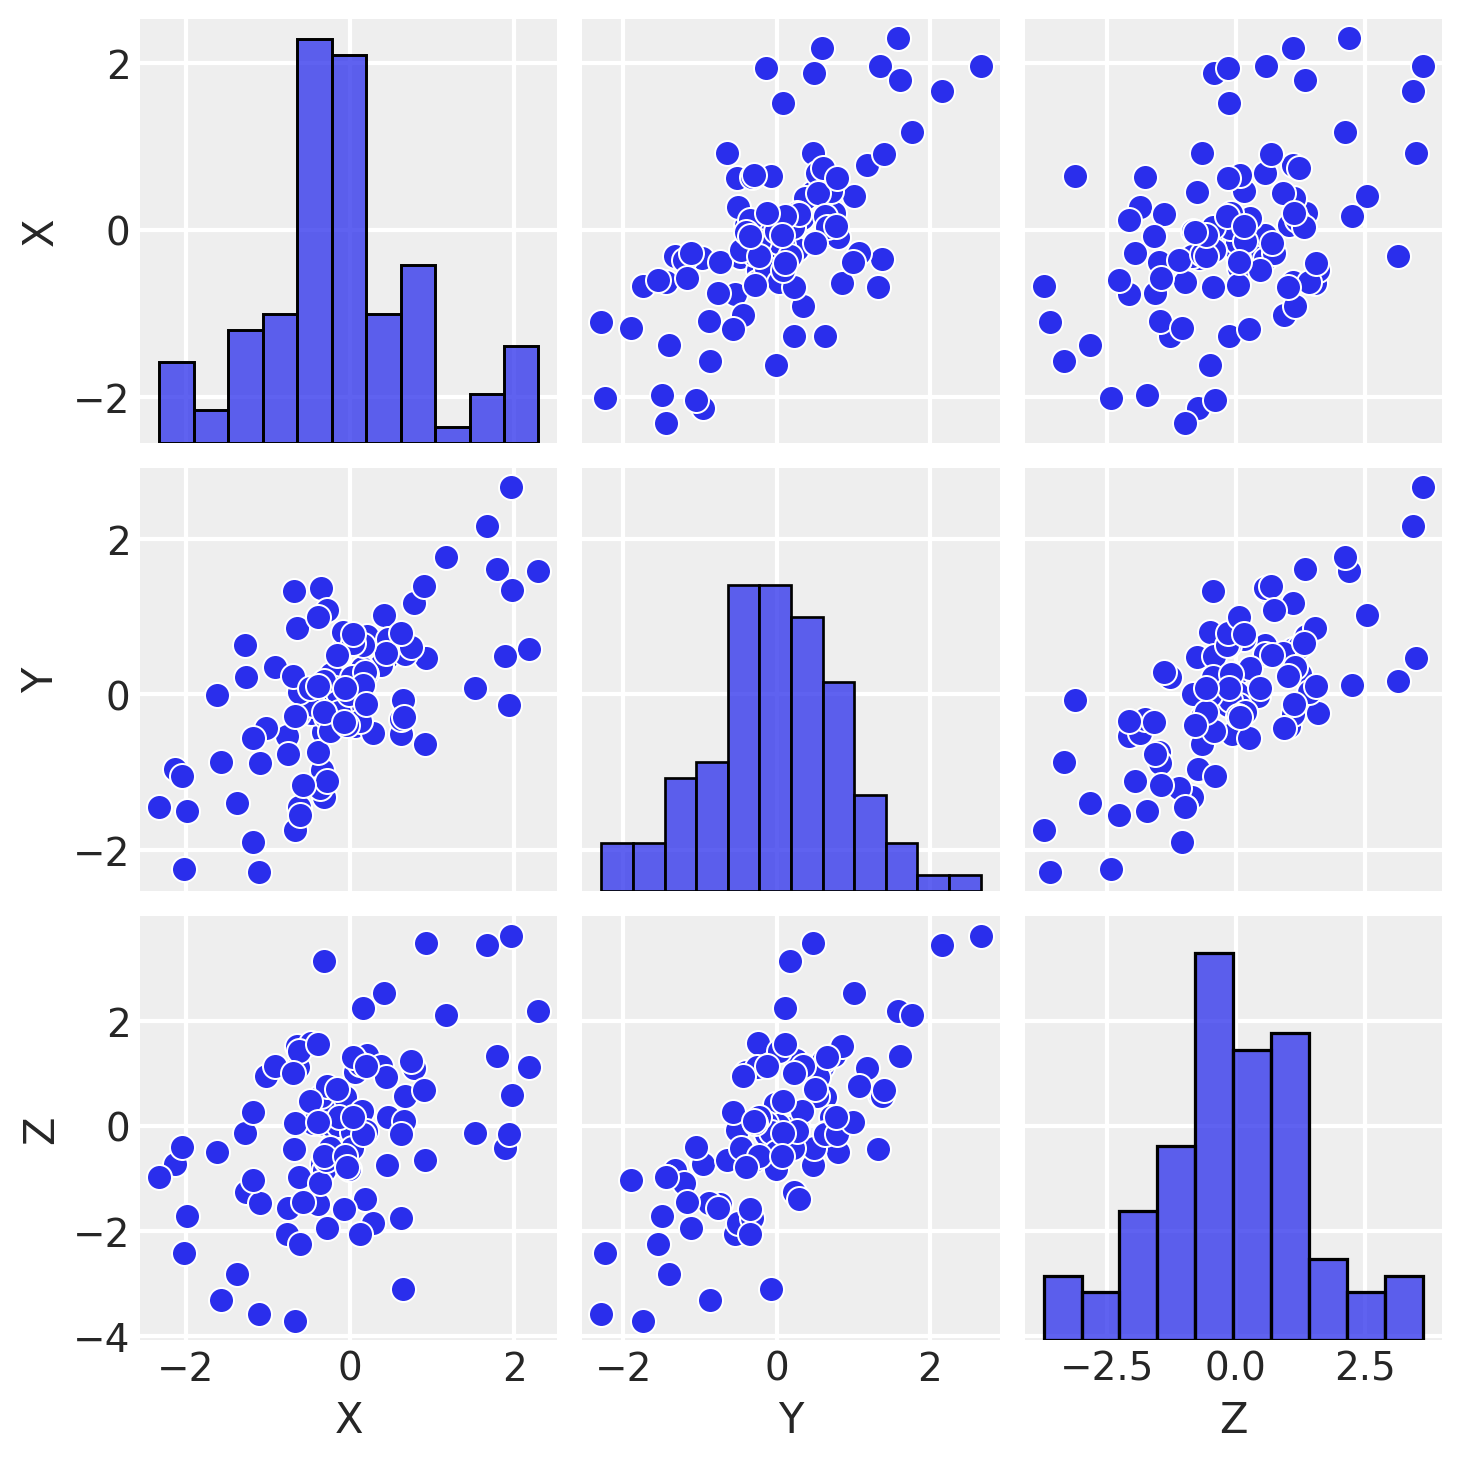

<IPython.core.display.Javascript object>

In [9]:
sns.pairplot(df_sim)

## Using only X as predictor variable

In [17]:
with pm.Model() as m15m4a:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = bx * df_sim['X']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4a = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [25]:
sm.OLS(df_sim["Y"], df_sim["X"]).fit().params

X    0.693398
dtype: float64

<IPython.core.display.Javascript object>

In [26]:
az.summary(trace_m15m4a)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bx,0.692,0.064,0.592,0.796,0.001,0.001,3569.0,3569.0,3578.0,2653.0,1.0
sigma,0.619,0.045,0.541,0.684,0.001,0.001,3512.0,3471.0,3569.0,2740.0,1.0


<IPython.core.display.Javascript object>

## Using X and Z as predictor variables

In [18]:
with pm.Model() as m15m4b:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = bx * df_sim['X'] + bz * df_sim['Z']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4b = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [27]:
sm.OLS(df_sim["Y"], df_sim[["X", "Z"]]).fit().params

X    0.542048
Z    0.266678
dtype: float64

<IPython.core.display.Javascript object>

In [28]:
az.summary(trace_m15m4b)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bx,0.542,0.064,0.439,0.642,0.001,0.001,3413.0,3413.0,3416.0,2685.0,1.0
bz,0.266,0.055,0.177,0.352,0.001,0.001,3106.0,3106.0,3103.0,2794.0,1.0
sigma,0.556,0.040,0.490,0.616,0.001,0.000,4507.0,4481.0,4485.0,2740.0,1.0


<IPython.core.display.Javascript object>

## Plot comparison

Text(0.5, 1.0, 'X (causal) and Z (descendant)')

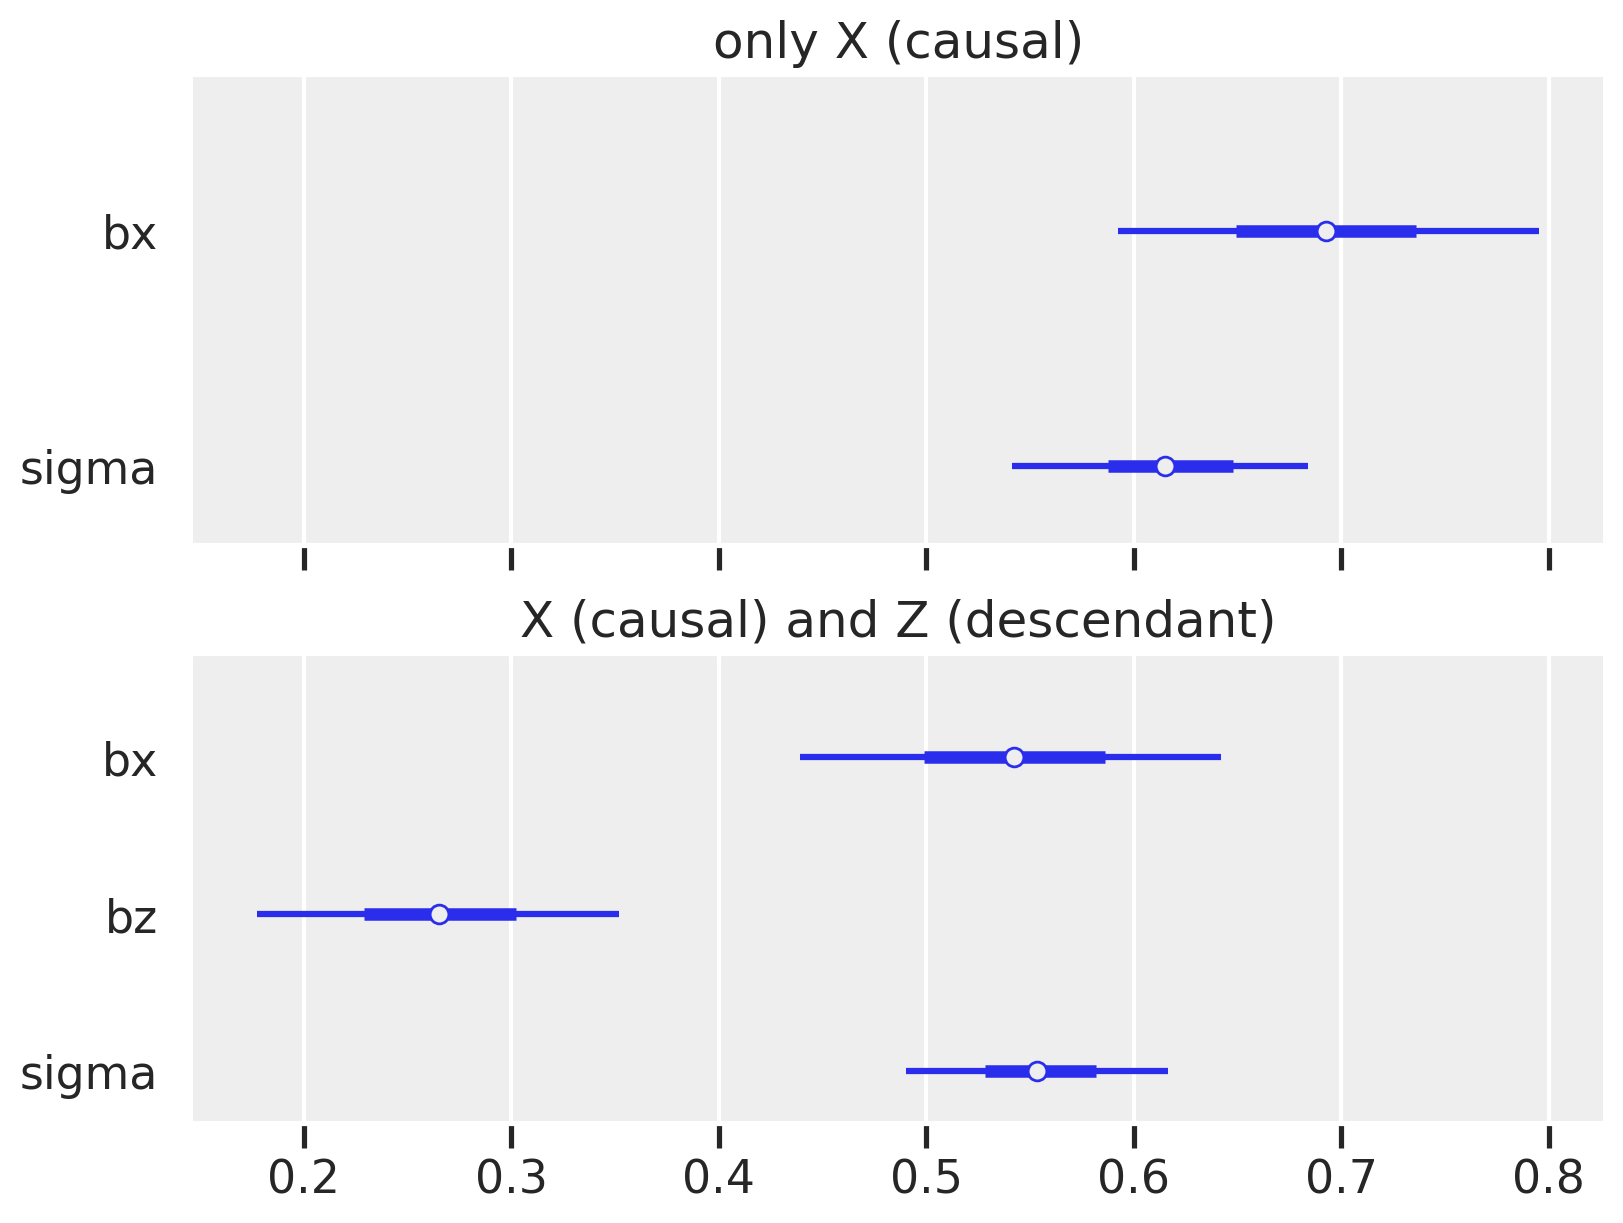

<IPython.core.display.Javascript object>

In [98]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
az.plot_forest(trace_m15m4a, combined=True, ax=ax1)
ax1.set_title("only X (causal)")

az.plot_forest(trace_m15m4b, combined=True, ax=ax2)
ax2.set_title("X (causal) and Z (descendant)")

Marco's tip:
- pretend z is like Y observed
- measurement error ....
- like shrinkage for coefficient



## Random stuff below

### Sample size impact

In [144]:
coef_list = list()
sample_size_list = [10, 100, 200, 500, 1000]
for ss in sample_size_list:
    X1 = stats.norm.rvs(0, 1, size=ss)
    # make y come from random draws of a normal distribution around x
    Y1 = stats.norm.rvs(X1, 1, size=ss)
    coef, se = sm.OLS(Y1, X1).fit().params, sm.OLS(Y1, X1).fit().bse
    coef_list.append((coef[0], se[0]))


<IPython.core.display.Javascript object>

array([0.41306031, 0.10459929, 0.07013674, 0.0455392 , 0.032457  ])

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'sample size'), Text(0, 0.5, 'standard error')]

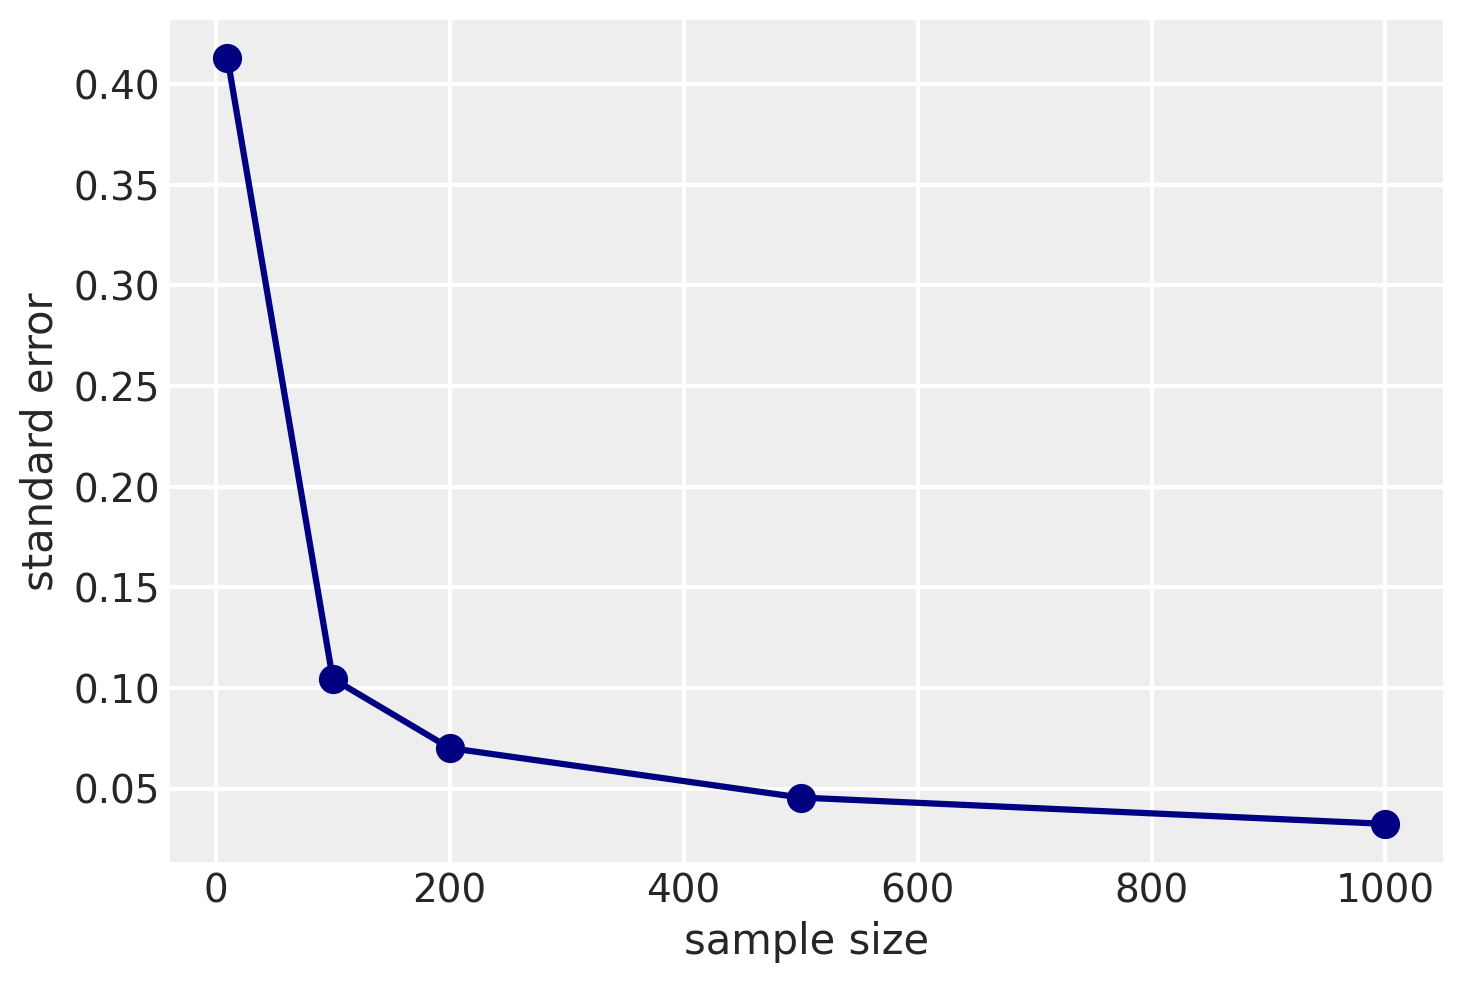

<IPython.core.display.Javascript object>

In [158]:
f, ax1 = plt.subplots()
for i, ss in enumerate(sample_size_list):
    ax1.scatter(ss, coef_list[i][1], label=str(ss), color='navy')
ax1.plot(sample_size_list, np.array(coef_list)[:, 1], color='navy')
ax1.set(xlabel='sample size', ylabel='standard error')

In [145]:
coef_list

[(1.4738356747569061, 0.4130603102642782),
 (1.1425773407005966, 0.10459929433531728),
 (0.9693379977060048, 0.07013674418669784),
 (0.9581939304346598, 0.045539195254065586),
 (0.9801280818471241, 0.03245700083272577)]

<IPython.core.display.Javascript object>

In [36]:
# start with x coming from random draws of a normal distribution around 0
X1 = stats.norm.rvs(0, 1, size=100)
# make y come from random draws of a normal distribution around x
Y1 = stats.norm.rvs(X1, 1, size=100)
# make z come from random draws of a normal distribution around x
Z1 = np.random.normal(Y1, 1, size=100)
# Z = np.random.normal(0, 1, size=100)*Y + 

df_sim = pd.DataFrame(
    {"X":X1, "Y":Y1, "Z":Z1}
)

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


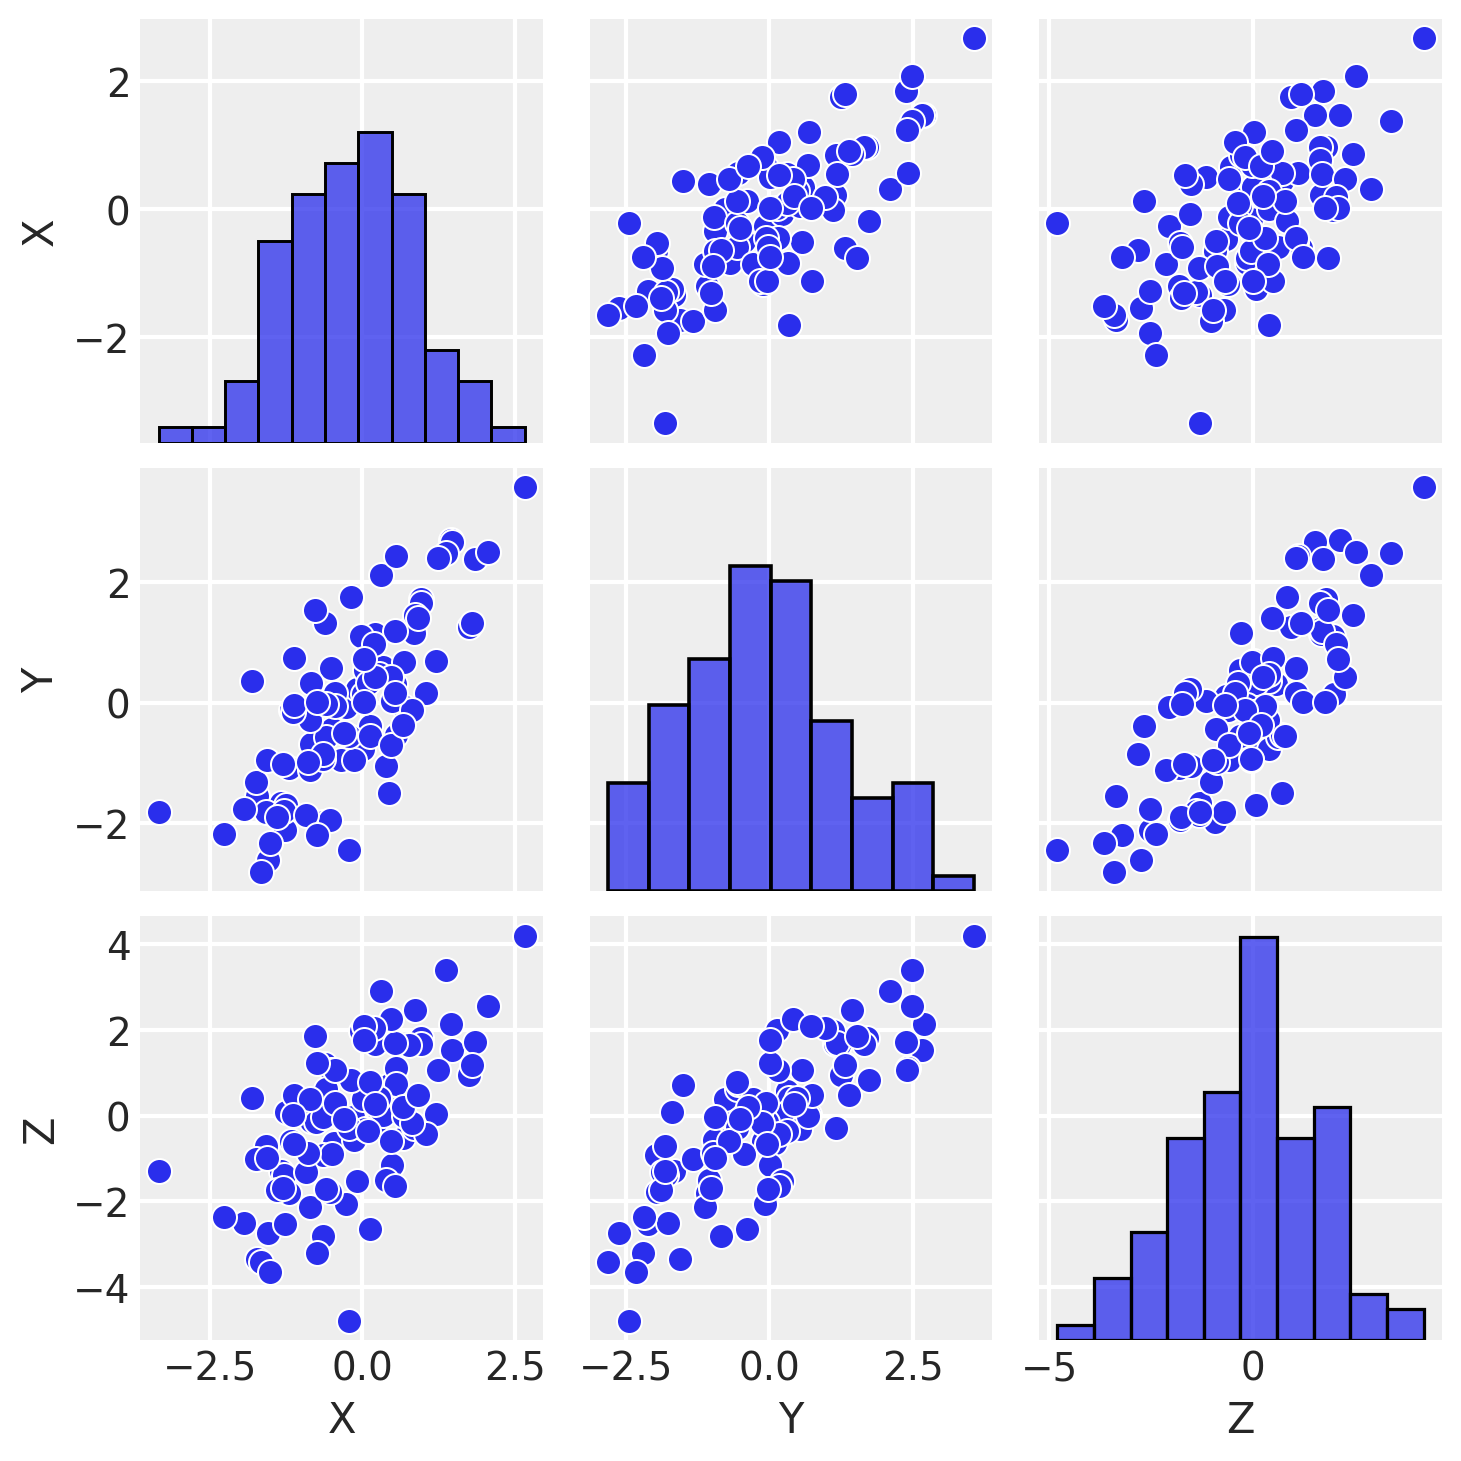

<IPython.core.display.Javascript object>

In [49]:
sns.pairplot(df_sim)

### Using `statsmodels`

In [45]:
import statsmodels.api as sm

<IPython.core.display.Javascript object>

In [47]:
res = sm.OLS(df_sim['Y'], df_sim['X']).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.551
Model:                            OLS   Adj. R-squared (uncentered):              0.546
Method:                 Least Squares   F-statistic:                              121.3
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                    6.85e-19
Time:                        16:25:34   Log-Likelihood:                         -133.42
No. Observations:                 100   AIC:                                      268.8
Df Residuals:                      99   BIC:                                      271.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.9658      0.088     11.013      0.000       0.792       1.140
==============================================================================
Omnibus:                        0.067   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.967   Jarque-Bera (JB):                0.207
Skew:                           0.044   Prob(JB):                        0.902
Kurtosis:                       2.796   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [48]:
res = sm.OLS(df_sim['Y'], df_sim[['X', 'Z']]).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.755
Model:                            OLS   Adj. R-squared (uncentered):              0.750
Method:                 Least Squares   F-statistic:                              150.9
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                    1.20e-30
Time:                        16:26:00   Log-Likelihood:                         -103.11
No. Observations:                 100   AIC:                                      210.2
Df Residuals:                      98   BIC:                                      215.4
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.5155      0.082      6.289      0.000       0.353       0.678
Z              0.4702      0.052      9.038      0.000       0.367       0.573
==============================================================================
Omnibus:                        0.927   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.629   Jarque-Bera (JB):                0.814
Skew:                          -0.219   Prob(JB):                        0.666
Kurtosis:                       2.943   Cond. No.                         2.36
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

## Using `pymc`

In [50]:
df_sim.head()

,X,Y,Z
0,0.198388,0.521408,-0.246524
1,1.459678,2.691161,2.144239
2,0.542236,0.309511,0.578994
3,-0.472632,0.101527,-0.640011
4,-1.727338,-1.557110,-3.349159


<IPython.core.display.Javascript object>

In [53]:
with pm.Model() as m15m4a:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X']

    # likelihood
    y = pm.Normal("h1", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4a = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

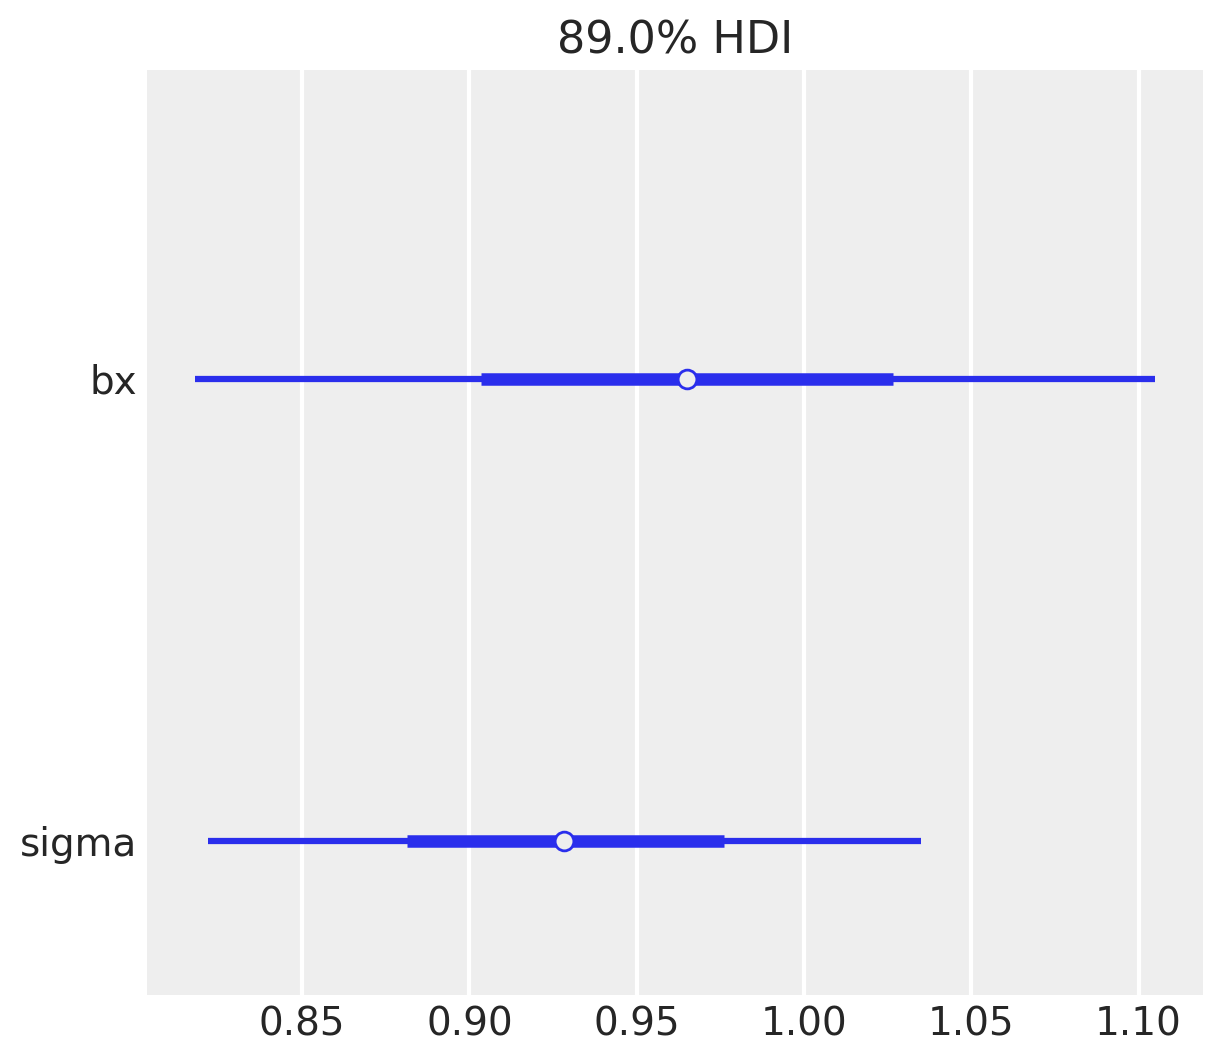

<IPython.core.display.Javascript object>

In [54]:
az.plot_forest(trace_m15m4a, combined=True)

In [56]:
with pm.Model() as m15m4b:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X'] + bz*df_sim['Z']

    # likelihood
    y = pm.Normal("h1", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4b = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

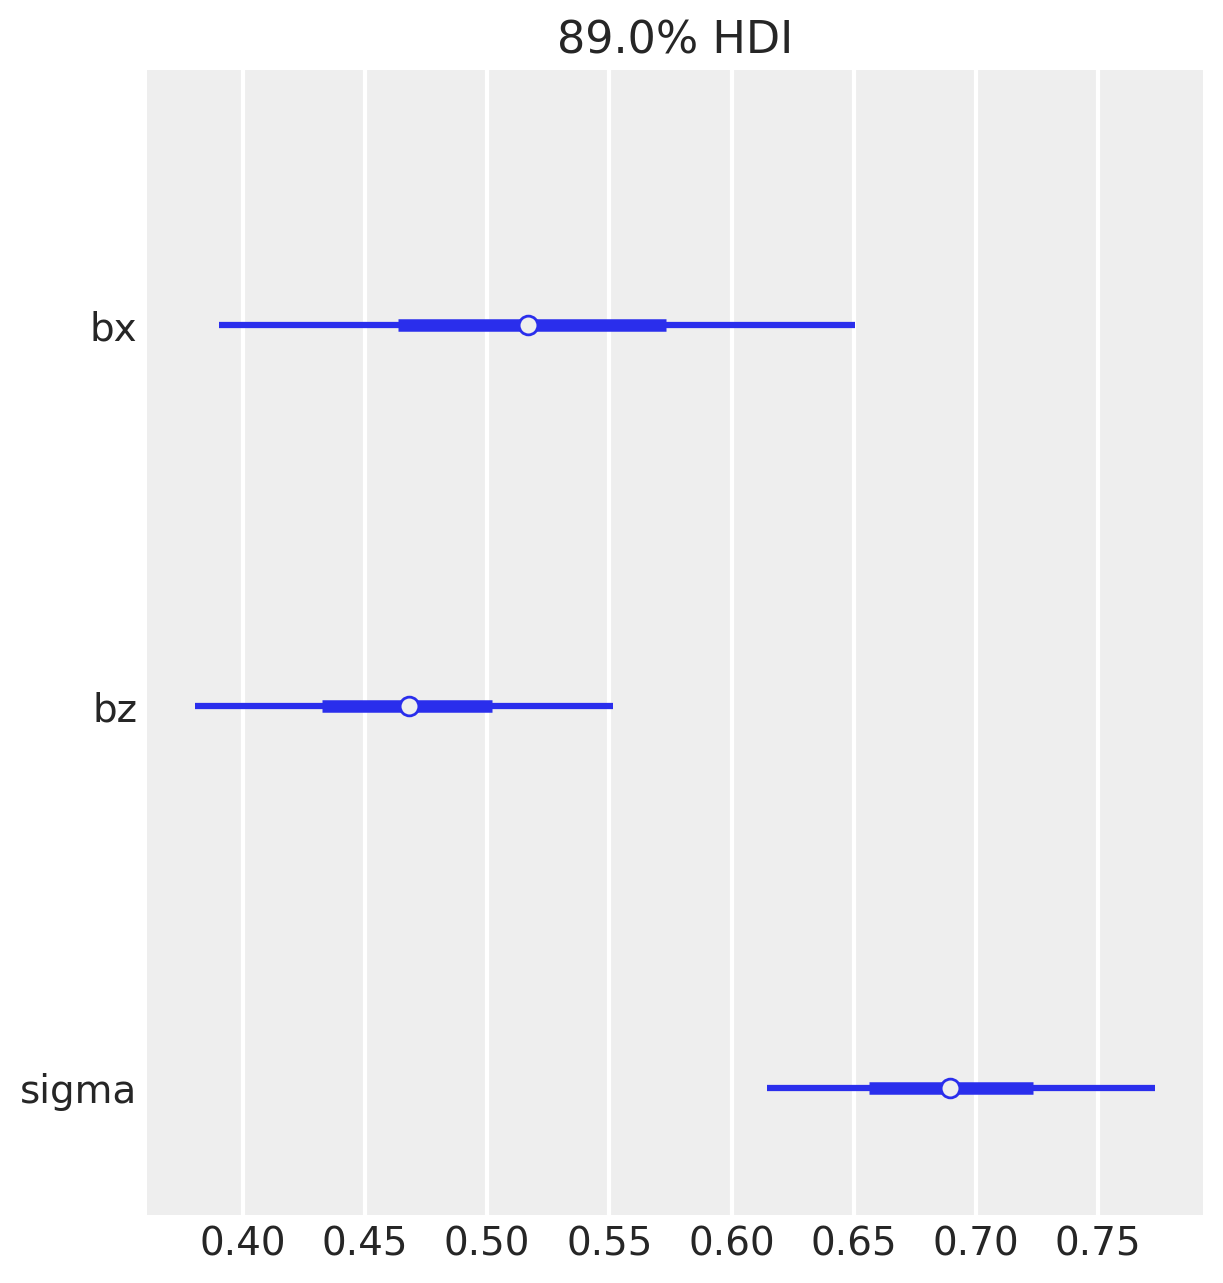

<IPython.core.display.Javascript object>

In [57]:
az.plot_forest(trace_m15m4b, combined=True)

In [ ]:
stats.linregress(X1, Y1)

## Change coefficient of sim

In [108]:
N_samples = 1000

# start with x coming from random draws of a normal distribution around 0
X1 = stats.norm.rvs(0, 1, size=N_samples)
bX_sim = 0.7

# make y come from random draws of a normal distribution around x
#Y1 = bX_sim * stats.norm.rvs(X1, 1, size=N_samples)
Y1 = stats.norm.rvs(bX_sim * X1, 1, size=N_samples)
# Y1 = bX_sim*X1
bY_sim = 0.3

# make z come from random draws of a normal distribution around x
Z1 = bY_sim * np.random.normal(Y1, 1, size=N_samples)
# Z = np.random.normal(0, 1, size=100)*Y + 

df_sim = pd.DataFrame(
    {"X":X1, "Y":Y1, "Z":Z1}
)

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Density'>

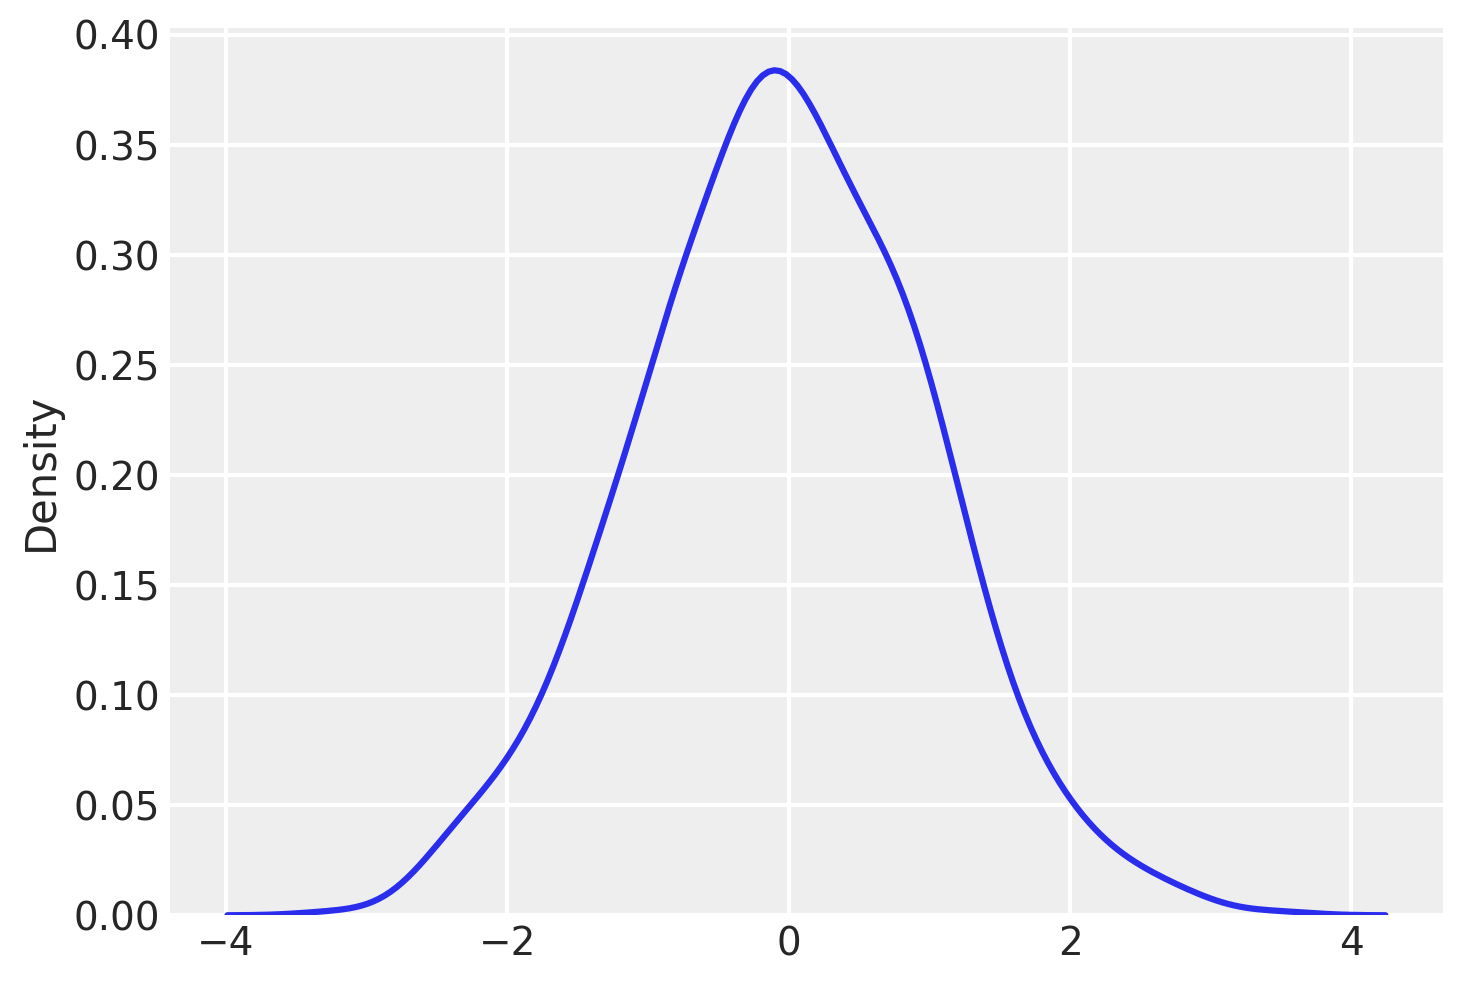

<IPython.core.display.Javascript object>

In [109]:
sns.kdeplot(X1)

In [103]:
(bX_sim * X1).mean()

0.097787496274374

<IPython.core.display.Javascript object>

In [101]:
X1.mean(), Y1.mean()

(0.13969642324910575, 0.15530444695953843)

<IPython.core.display.Javascript object>

In [100]:
0.7*0.3

0.21

<IPython.core.display.Javascript object>

In [110]:
sm.OLS(df_sim['Y'], df_sim[['X']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.354
Model:                            OLS   Adj. R-squared (uncentered):              0.354
Method:                 Least Squares   F-statistic:                              548.4
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                    5.08e-97
Time:                        18:07:42   Log-Likelihood:                         -1415.7
No. Observations:                1000   AIC:                                      2833.
Df Residuals:                     999   BIC:                                      2838.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.7177      0.031     23.417      0.000       0.658       0.778
==============================================================================
Omnibus:                        6.535   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                8.102
Skew:                           0.070   Prob(JB):                       0.0174
Kurtosis:                       3.418   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [111]:
sm.OLS(df_sim['Y'], df_sim[['X', 'Z']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.672
Model:                            OLS   Adj. R-squared (uncentered):              0.671
Method:                 Least Squares   F-statistic:                              1023.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                   2.32e-242
Time:                        18:08:07   Log-Likelihood:                         -1076.9
No. Observations:                1000   AIC:                                      2158.
Df Residuals:                     998   BIC:                                      2168.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.3742      0.024     15.281      0.000       0.326       0.422
Z              1.6637      0.054     31.095      0.000       1.559       1.769
==============================================================================
Omnibus:                        2.397   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                2.265
Skew:                           0.090   Prob(JB):                        0.322
Kurtosis:                       3.148   Cond. No.                         2.57
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


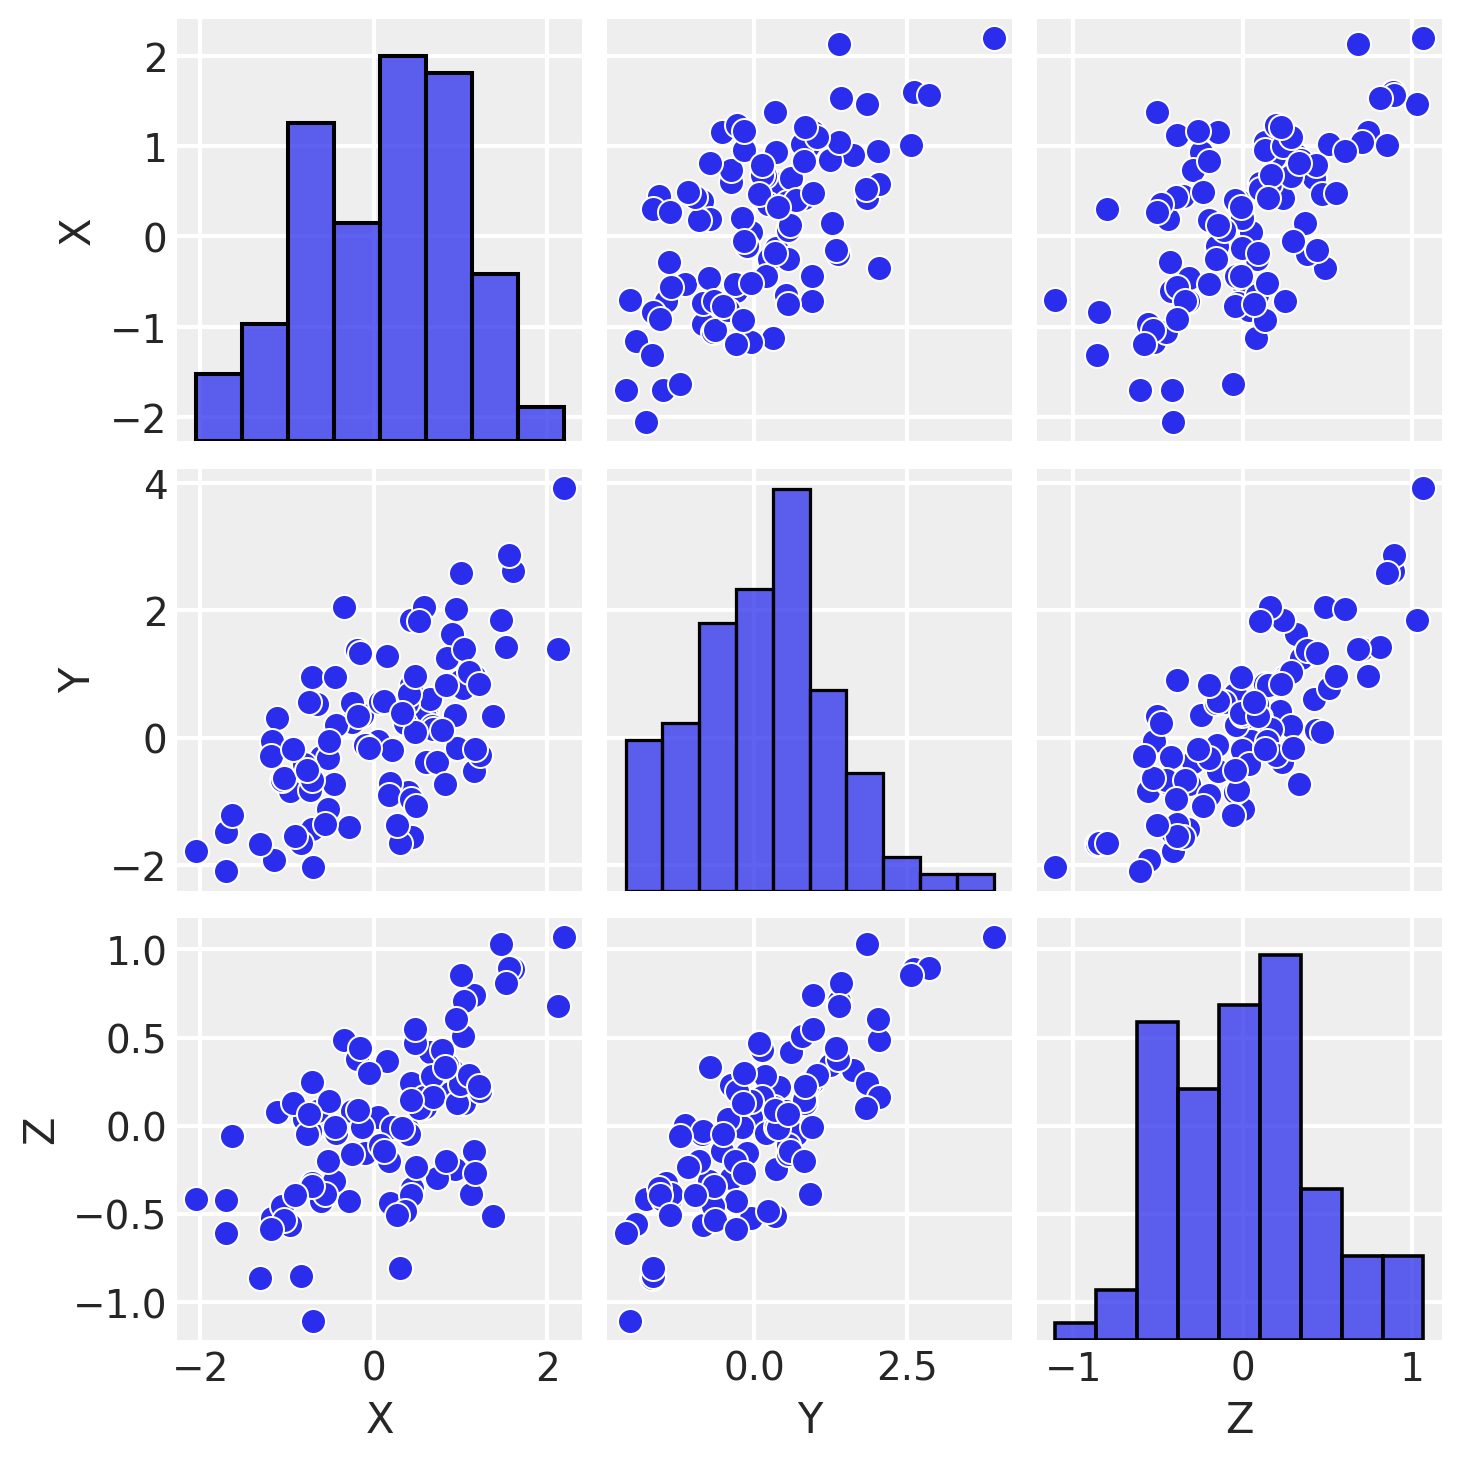

<IPython.core.display.Javascript object>

In [97]:
sns.pairplot(df_sim)

In [112]:
sm.OLS(df_sim['Y'], df_sim[['Z']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.595
Model:                            OLS   Adj. R-squared (uncentered):              0.595
Method:                 Least Squares   F-statistic:                              1470.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                   1.76e-198
Time:                        18:08:37   Log-Likelihood:                         -1182.1
No. Observations:                1000   AIC:                                      2366.
Df Residuals:                     999   BIC:                                      2371.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Z              2.0326      0.053     38.339      0.000       1.929       2.137
==============================================================================
Omnibus:                        3.821   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                3.678
Skew:                           0.132   Prob(JB):                        0.159
Kurtosis:                       3.136   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

## Change the outcome

In [113]:
sm.OLS(df_sim['Z'], df_sim[['X', 'Y']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Z   R-squared (uncentered):                   0.595
Model:                            OLS   Adj. R-squared (uncentered):              0.595
Method:                 Least Squares   F-statistic:                              734.5
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                   7.45e-197
Time:                        18:09:26   Log-Likelihood:                         -213.32
No. Observations:                1000   AIC:                                      430.6
Df Residuals:                     998   BIC:                                      440.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             -0.0058      0.011     -0.506      0.613      -0.028       0.017
Y              0.2958      0.010     31.095      0.000       0.277       0.314
==============================================================================
Omnibus:                        2.486   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.288   Jarque-Bera (JB):                2.438
Skew:                          -0.121   Prob(JB):                        0.296
Kurtosis:                       3.011   Cond. No.                         2.04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [117]:
sm.OLS(df_sim['Z'], df_sim[['Y']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Z   R-squared (uncentered):                   0.595
Model:                            OLS   Adj. R-squared (uncentered):              0.595
Method:                 Least Squares   F-statistic:                              1470.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                   1.76e-198
Time:                        18:10:13   Log-Likelihood:                         -213.45
No. Observations:                1000   AIC:                                      428.9
Df Residuals:                     999   BIC:                                      433.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Y              0.2929      0.008     38.339      0.000       0.278       0.308
==============================================================================
Omnibus:                        2.608   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.271   Jarque-Bera (JB):                2.559
Skew:                          -0.124   Prob(JB):                        0.278
Kurtosis:                       3.012   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [118]:
sm.OLS(df_sim['Z'], df_sim[['X']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Z   R-squared (uncentered):                   0.204
Model:                            OLS   Adj. R-squared (uncentered):              0.203
Method:                 Least Squares   F-statistic:                              255.3
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                    2.38e-51
Time:                        18:10:30   Log-Likelihood:                         -552.03
No. Observations:                1000   AIC:                                      1106.
Df Residuals:                     999   BIC:                                      1111.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.2065      0.013     15.978      0.000       0.181       0.232
==============================================================================
Omnibus:                        1.707   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.426   Jarque-Bera (JB):                1.607
Skew:                          -0.095   Prob(JB):                        0.448
Kurtosis:                       3.051   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [119]:
sm.OLS(df_sim['Z'], df_sim[['X']]).fit().params

X    0.206468
dtype: float64

<IPython.core.display.Javascript object>

In [120]:
sm.OLS(df_sim['Z'], df_sim[['X', 'Y']]).fit().params

X   -0.005799
Y    0.295766
dtype: float64

<IPython.core.display.Javascript object>

## Colliders pointing to Z

In [121]:
N_samples = 1000

# start with x coming from random draws of a normal distribution around 0
X1 = stats.norm.rvs(0, 1, size=N_samples)
bX_sim = 0.7

# make y come from random draws of a normal distribution around x
#Y1 = bX_sim * stats.norm.rvs(X1, 1, size=N_samples)
Y1 = stats.norm.rvs(1, 1, size=N_samples)
# Y1 = bX_sim*X1
bY_sim = 0.3

# make z come from random draws of a normal distribution around x
Z1 = bX_sim * np.random.normal(X1, 1, size=N_samples) + bY_sim * np.random.normal(Y1, 1, size=N_samples) 
# Z = np.random.normal(0, 1, size=100)*Y + 

df_sim = pd.DataFrame(
    {"X":X1, "Y":Y1, "Z":Z1}
)

<IPython.core.display.Javascript object>

In [122]:
sm.OLS(df_sim['Z'], df_sim[['X', 'Y']]).fit().params

X    0.674042
Y    0.298147
dtype: float64

<IPython.core.display.Javascript object>

In [123]:
sm.OLS(df_sim['Z'], df_sim[['X']]).fit().params

X    0.667398
dtype: float64

<IPython.core.display.Javascript object>

In [124]:
sm.OLS(df_sim['Z'], df_sim[['Y']]).fit().params

Y    0.290141
dtype: float64

<IPython.core.display.Javascript object>

In [125]:
sm.OLS(df_sim['X'], df_sim[['Y']]).fit().params

Y   -0.011876
dtype: float64

<IPython.core.display.Javascript object>

In [126]:
sm.OLS(df_sim['X'], df_sim[['Y', 'Z']]).fit().params

Y   -0.210500
Z    0.684574
dtype: float64

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


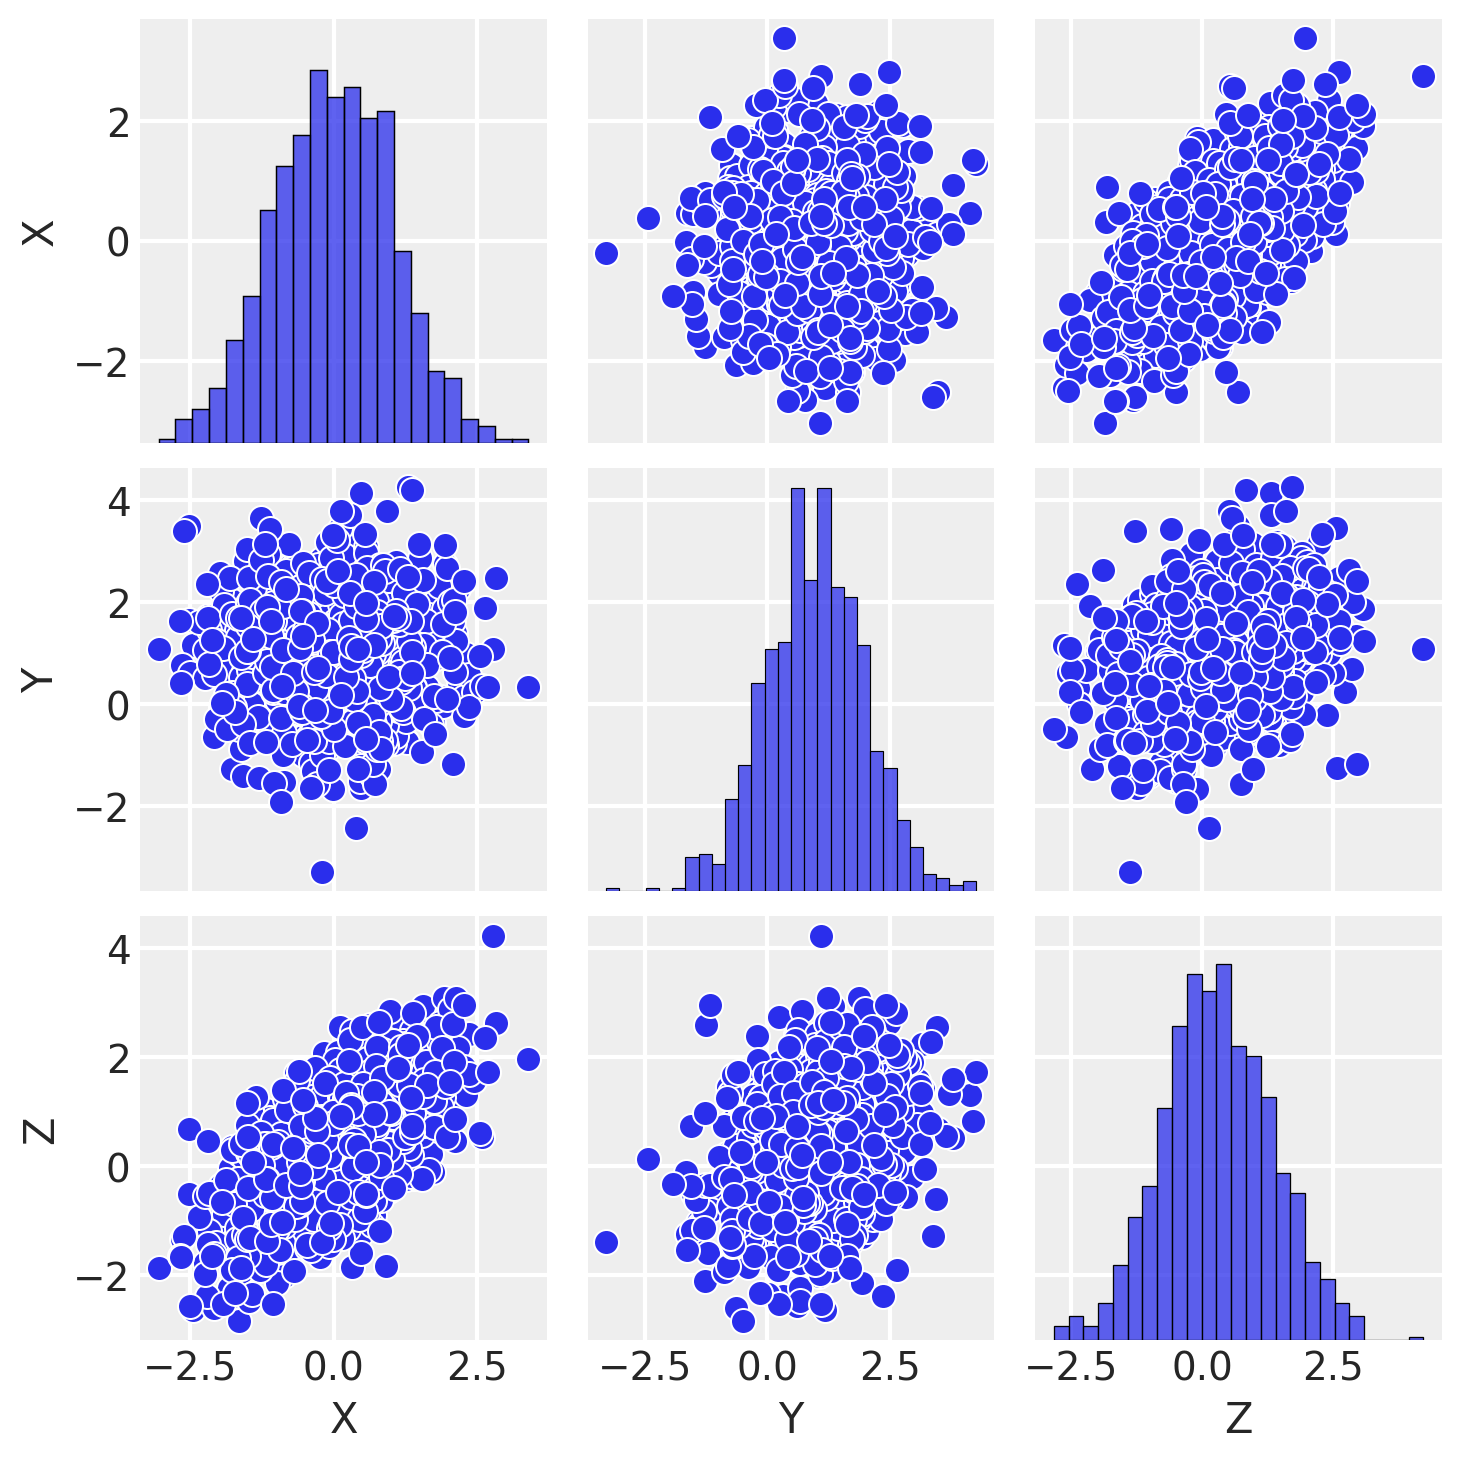

<IPython.core.display.Javascript object>

In [127]:
sns.pairplot(df_sim)

In [85]:
with pm.Model() as m15m4a:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4a = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

In [87]:
with pm.Model() as m15m4b:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X'] + bz*df_sim['Z']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4b = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

In [89]:
with pm.Model() as m15m4c:
    
    # priors
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bz*df_sim['Z']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4c = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4c = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

In [92]:
az.summary(trace_m15m4a)
# az.plot_forest(trace_m15m4b, combined=True, ax=ax2)
# az.plot_forest(trace_m15m4c, combined=True, ax=ax3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bx,0.620,0.073,0.507,0.736,0.001,0.001,3439.0,3439.0,3449.0,2680.0,1.0
sigma,0.721,0.052,0.641,0.802,0.001,0.001,3362.0,3287.0,3491.0,2438.0,1.0


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

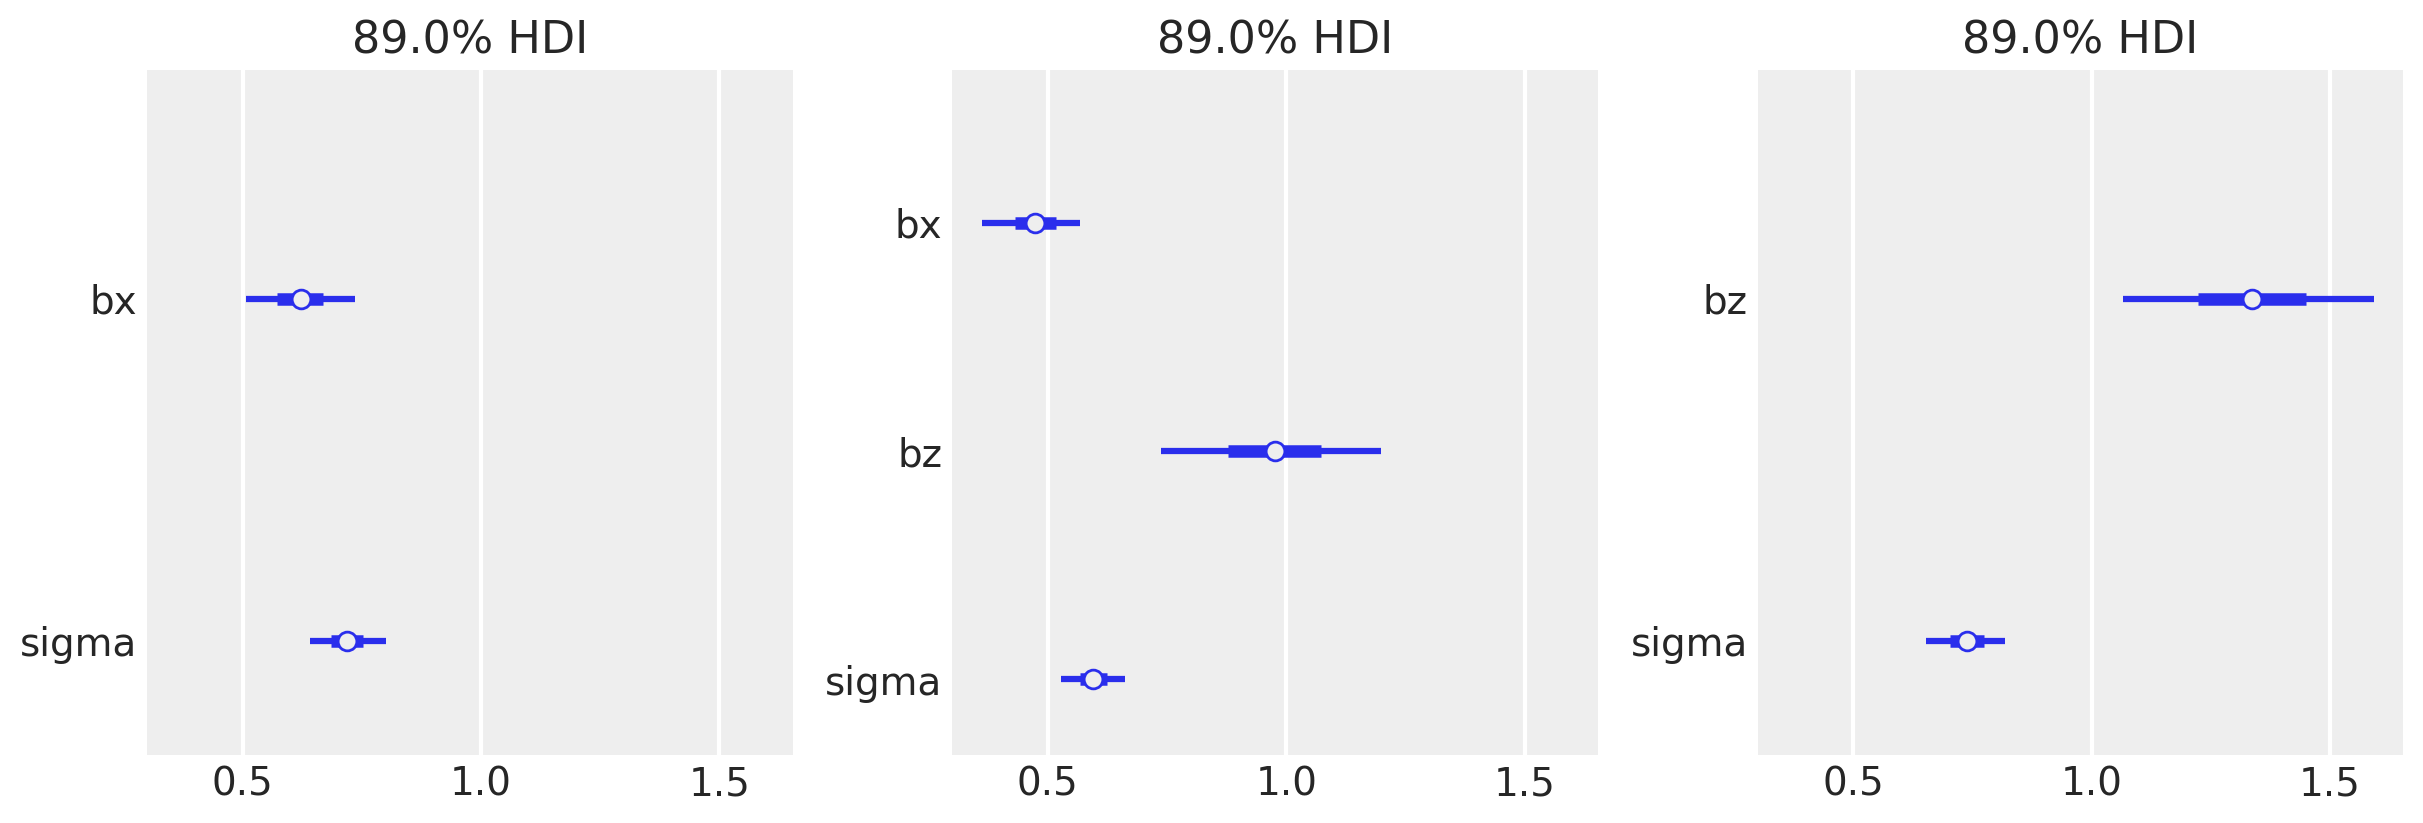

<IPython.core.display.Javascript object>

In [90]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
az.plot_forest(trace_m15m4a, combined=True, ax=ax1)
az.plot_forest(trace_m15m4b, combined=True, ax=ax2)
az.plot_forest(trace_m15m4c, combined=True, ax=ax3)

## Post with mediator, fork, collider

- have arrows pointing in different directions (X > Y > Z; X > Y < Z)
- have outcomes vary, in each condition (predict Y, predict Z, etc.)
- show how all can be correlated
- impact of sample size

## Post with binomial versus normal distributions
- variable is continuous versus categorical

## Impact of different kinds of simulations/magnitudes

Scott's R code

```
n <- 10000
x <- rnorm(n)
y <- 0.5*x+rnorm(n)
z <- 0.4*y+rnorm(n)

d <- data.frame(x,y,z)
lm(y~z+x)
lm(y~x)
```

In [71]:
n = 10**5
x = stats.norm.rvs(size=n)
y = 0.5*x + stats.norm.rvs(n)
z = 0.4*y + stats.norm.rvs(n)

df_sim2 = pd.DataFrame({"X":x, "Y":y, "Z":z})


<IPython.core.display.Javascript object>

In [72]:
sm.OLS(df_sim2['Y'], df_sim2[['X']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                            0.03933
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                       0.843
Time:                        17:04:54   Log-Likelihood:                     -1.2932e+06
No. Observations:              100000   AIC:                                  2.586e+06
Df Residuals:                   99999   BIC:                                  2.586e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X            -62.7574    316.467     -0.198      0.843    -683.028     557.513
==============================================================================
Omnibus:                        0.823   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.663   Jarque-Bera (JB):                0.826
Skew:                          -0.007   Prob(JB):                        0.662
Kurtosis:                       2.997   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [73]:
sm.OLS(df_sim2['Y'], df_sim2[['X', 'Z']]).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.964e+24
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:05:10   Log-Likelihood:             2.2187e+06
No. Observations:              100000   AIC:                        -4.437e+06
Df Residuals:                   99998   BIC:                        -4.437e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.3571   1.77e-13   2.02e+12      0.000       0.357       0.357
Z              0.7143   1.26e-18   5.65e+17      0.000       0.714       0.714
==============================================================================
Omnibus:                      777.903   Durbin-Watson:                   0.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              536.605
Skew:                          -0.047   Prob(JB):                    3.00e-117
Kurtosis:                       2.654   Cond. No.                     1.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

In [77]:
with pm.Model() as m15m4_2a:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # sample
    trace_m15m4_2a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

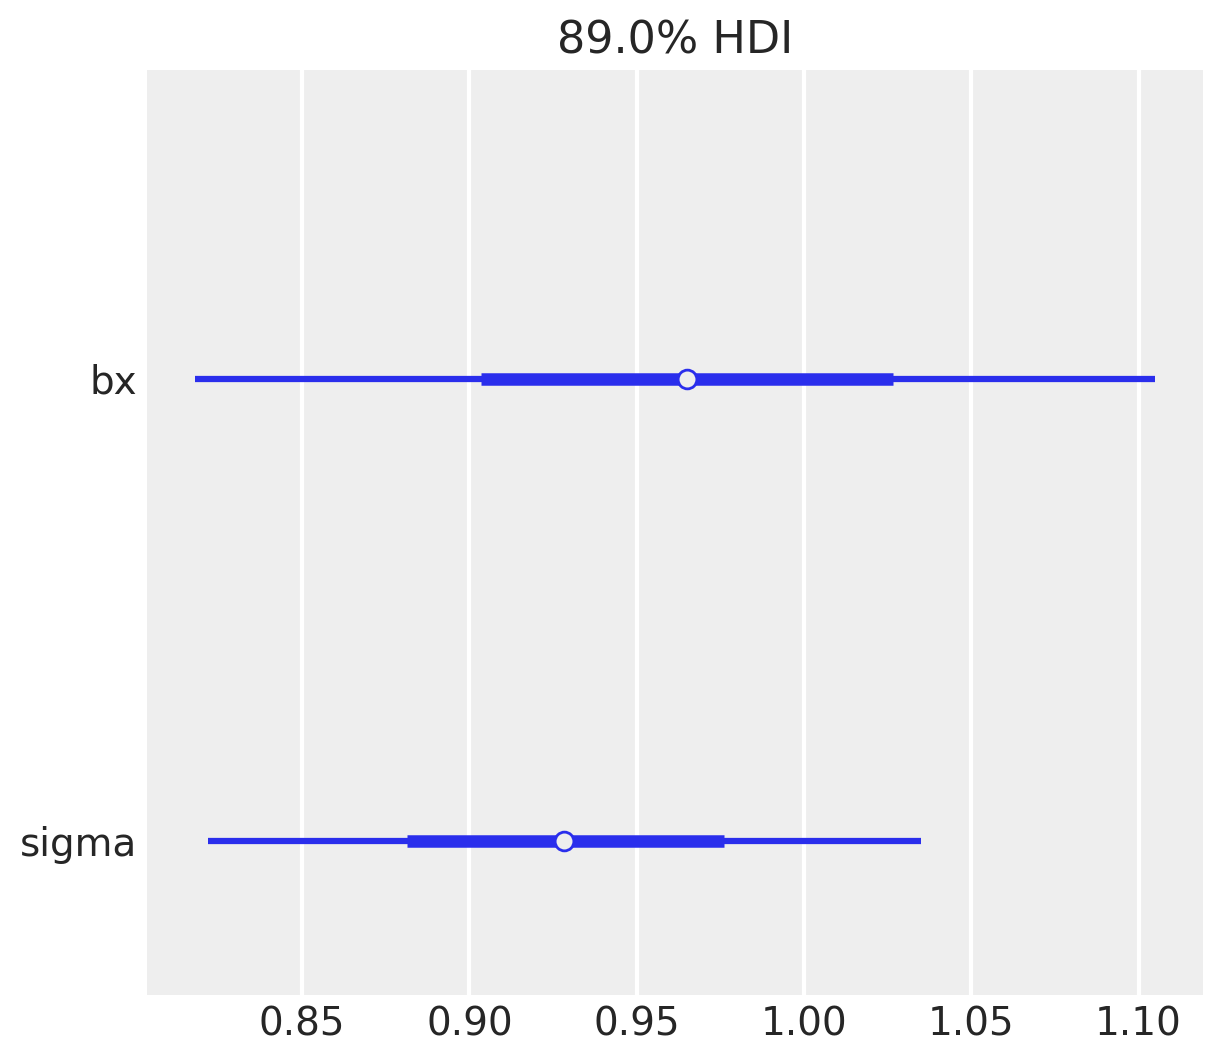

<IPython.core.display.Javascript object>

In [79]:
with pm.Model() as m15m4_2b:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X'] + bz*df_sim['Z']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # sample
    trace_m15m4_2b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

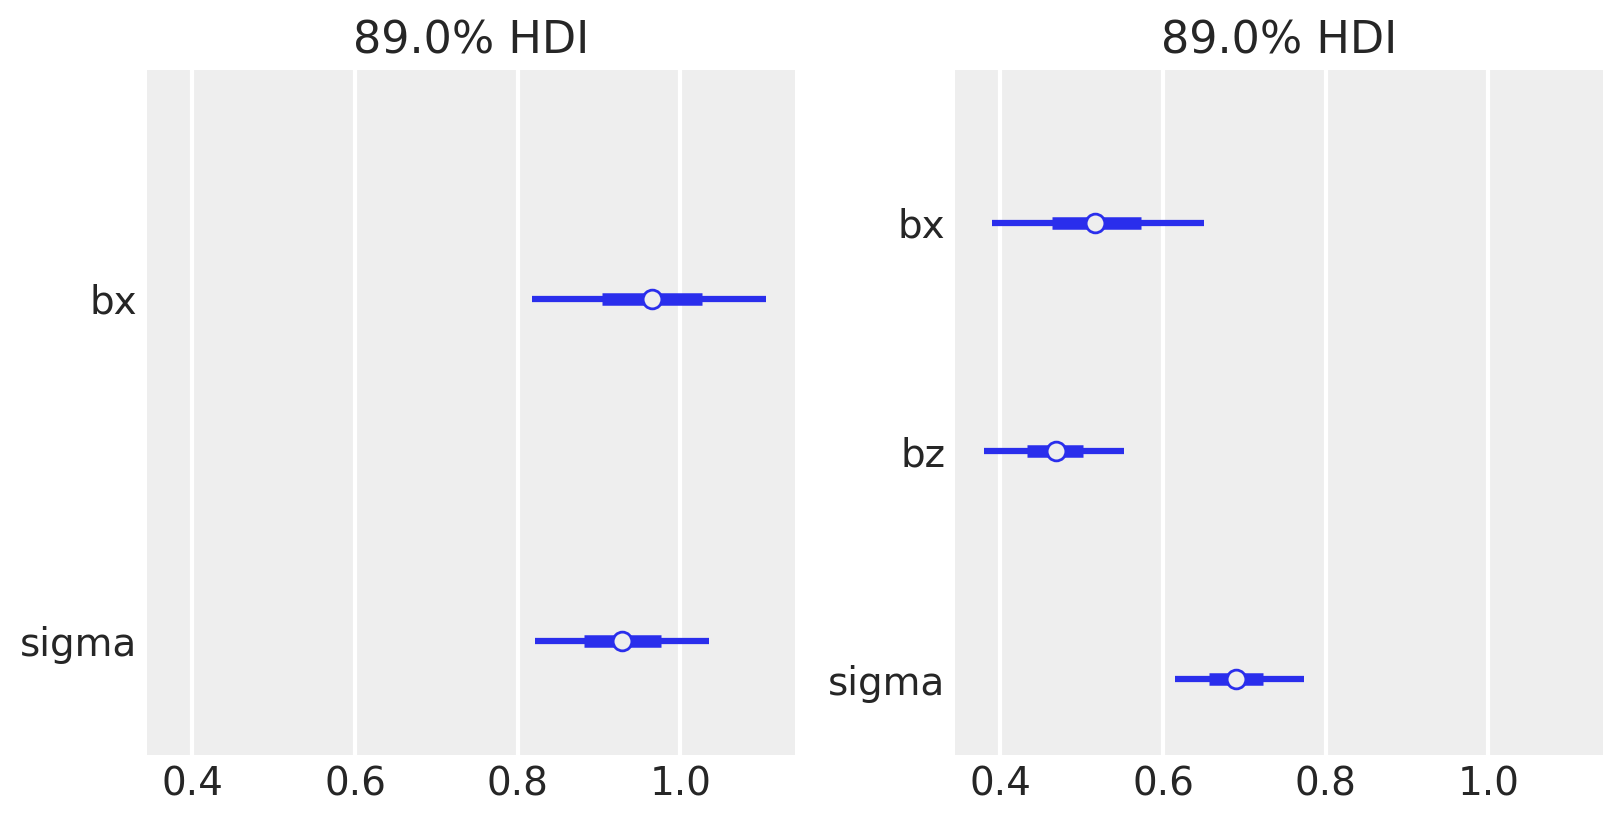

<IPython.core.display.Javascript object>

In [81]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
az.plot_forest(trace_m15m4_2a, combined=True, ax=ax1)
az.plot_forest(trace_m15m4_2b, combined=True, ax=ax2)

In [22]:
X = np.random.normal(0, 1, size=100)
Y = np.random.normal(0, 1, size=100)*X + 0.25
Z = np.random.normal(0, 1, size=100)*Y + 1

df = pd.DataFrame(np.array([X,Y,Z]).reshape(100,3))
df.columns = ['X', 'Y', 'Z']

<IPython.core.display.Javascript object>

In [ ]:
az.plot_forest(trace_m15m4b, combined=True)

In [52]:
df.iloc[:, 1:3].corr()

,Y,Z
Y,1.000000,0.284929
Z,0.284929,1.000000


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


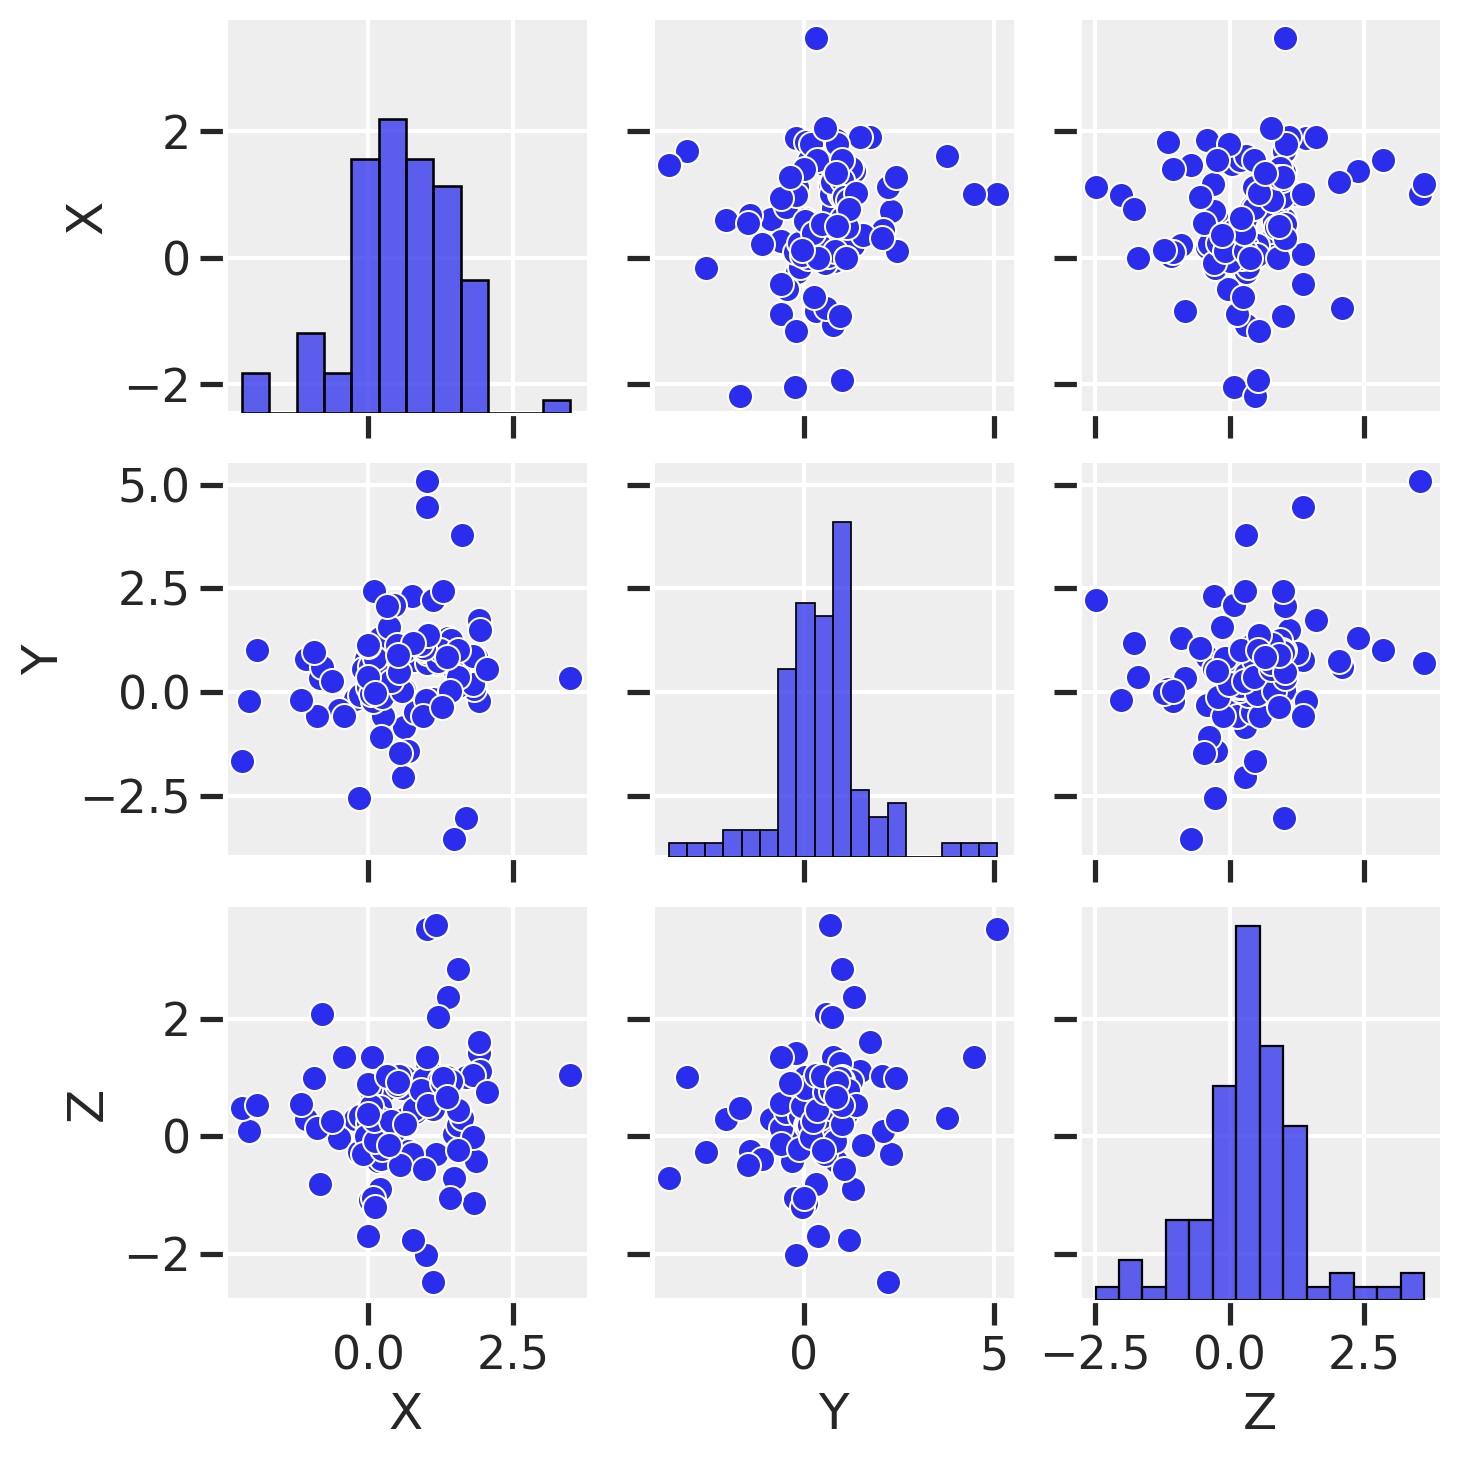

<IPython.core.display.Javascript object>

In [48]:
sns.pairplot(df)

In [ ]:
sns.

In [ ]:
with pm.Model() as m1:

    # prior
    a = pm.Normal()


    # likelihood?


    

### Simulation from McElreath's causal salad lecture

McElreath's [causal salad](https://github.com/rmcelreath/causal_salad_2021/blob/main/1_causal_salad.r) example.

In [ ]:
# 

## Back to Section 3.3

I still didn't understand above, so he explitly goes over simulation to simulate prediction here.

In [53]:
from scipy.stats import binom

<IPython.core.display.Javascript object>

Probability of observing 0, 1, 2 water for three tosses of the globe.

In [126]:
# dbinom( 0:2,size=2,prob=0.7)
# n = tosses of the globe
# k = list of desired observations (range(3)) is 0,1,2
stats.binom.pmf(k=[0,1,2], n=2, p=0.7)


array([0.09, 0.42, 0.49])

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [4]:
%watermark -n -u -v -iv -w

Last updated: Tue Dec 21 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

statsmodels: 0.12.2
scipy      : 1.6.0
arviz      : 0.11.1
numpy      : 1.20.1
daft       : 0.1.0
pandas     : 1.2.1
matplotlib : 3.3.4
pymc3      : 3.11.0
json       : 2.0.9
seaborn    : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>